## imports


In [19]:
# !ls /datasets/aurora

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [20]:
# bash ssh_keys/load_ssh3.sh

In [21]:
! sudo apt remove -y python3-numpy python3-scipy
!pip install torch==2.5.0 torchvision==0.20.0 torchaudio==2.5.0 --index-url https://download.pytorch.org/whl/cu124
!pip install cdsapi dask xarray netcdf4 matplotlib microsoft-aurora boto3 awscli
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
!pip install scikit-learn
!pip install imblearn
# ! pip install smote-variants


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package 'python3-scipy' is not installed, so not removed
Package 'python3-numpy' is not installed, so not removed
The following packages were automatically installed and are no longer required:
  cudnn-license fonts-lyx libabsl20210324 libaec0 libboost-dev
  libboost1.74-dev libc-ares2 libdouble-conversion3 libgif7 libhdf5-103-1
  libhdf5-hl-100 libimagequant0 libjs-jquery-ui liblbfgsb0 liblzf1 libmagma2
  libopenblas-dev libopenblas-pthread-dev libopenblas0 libqhull-r8.0 libraqm0
  libsz2 libwebpdemux2 libxsimd-dev python-matplotlib-data python3-absl
  python3-appdirs python3-astunparse python3-beniget python3-bleach
  python3-brotli python3-bs4 python3-cycler python3-einops python3-flatbuffers
  python3-fs python3-fsspec python3-gast python3-grpcio python3-html5lib
  python3-joblib python3-kiwisolver python3-lxml python3-lz4 python3-mpmath
  python3-namex python3-networkx python3-olefile 

tthe next two boxes are used for using aws cli 

In [22]:
# !aws --version

In [23]:
# see awsid

In [24]:
import xarray as xr
from tqdm import tqdm
from aurora import Batch, Metadata
import os
import glob
import re
import boto3
from io import BytesIO
import io
import pandas as pd
import torch.nn.functional as F
from aurora import Aurora
from aurora.normalisation import locations, scales
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torch.nn as nn
import torch.optim as optim
import torch
import sklearn
import numpy as np
import gc
# from netCDF4 import Dataset
# import h5py
import matplotlib.pyplot as plt
# from imblearn.over_sampling import SMOTE
# from imblearn.over_sampling import SMOTENC
# import smote_variants as sv
from scipy.ndimage import distance_transform_edt
from scipy.ndimage import binary_dilation
from sklearn.metrics import precision_recall_curve, auc


## aurora dataset maker

In [25]:
# Normalisation means:
# locations["fire"] = 0.0
# locations["lst"] = 11484.10859

# Normalisation standard deviations:
# scales["fire"] = 1.0
# scales["lst"] = 8109.33224

# variables_to_keep = ['u10', 'v10', 't2m', 'msl', 'fire']
# variables_to_keep = ['u10', 'v10', 't2m', 'msl', 'lst', 'fire']

def data_retreive ( atmos_files, surf_files, date_range, days, idx , variables_to_keep = None ):
    date_window = date_range[idx:idx + days]
    # print(date_range)
    # print(idx)
    # print(days)
    atmos_regex = []
    surf_regex = []
    for day in range(days):
        # note that no need to look at download path here because its already accounted for when globing inside of aurora dataset
        atmos_regex.append( re.compile( rf".*/{date_window[day].strftime('%Y%m')}/atmospheric_{date_window[day].strftime('%Y%m%d')}\.nc$"))
        surf_regex.append( re.compile( rf".*/surf_{date_window[day].strftime('%Y-%m-%d')}\.nc$"))

    atmos_filt = [f for f in atmos_files if any(d.match(f) for d in atmos_regex)]
    surf_filt = [f for f in surf_files if any(d.match(f) for d in surf_regex)]
    atmos_list = []
    surf_list = []
    # print(atmos_filt)
    # print("surf")
    # print(surf_filt)
    ds = xr.open_dataset(atmos_filt[0]).load()
    ds.close()

    # for day in range(len(atmos_filt)):
    for day in range(days):
        with xr.open_dataset(atmos_filt[day])as atmos_cur, xr.open_dataset(surf_filt[day]) as surf_cur :
            # code for dropping variables. makes code run slower. interpolation so fast that it doest matter. 
            if variables_to_keep is not None:
                surf_cur = surf_cur.drop_vars([var for var in surf_cur.data_vars if var not in variables_to_keep])

            atmos_list.append(atmos_cur.load())
            surf_list.append(surf_cur.load())

    atmos_comb = xr.concat(atmos_list, dim="valid_time")
    surf_comb = xr.concat(surf_list, dim="valid_time")
    return atmos_comb, surf_comb

def feature_label_batch(atmos_comb, surf_comb, static, interpolated_static_vars):
    i = 1  
    batch = Batch(
        surf_vars={
            # First select time points `i` and `i - 1`. Afterwards, `[None]` inserts a
            # batch dimension of size one.
            "2t": torch.from_numpy(surf_comb["t2m"].values[[i - 1, i]][None]),
            "10u": torch.from_numpy(surf_comb["u10"].values[[i - 1, i]][None]),
            "10v": torch.from_numpy(surf_comb["v10"].values[[i - 1, i]][None]),
            "msl": torch.from_numpy(surf_comb["msl"].values[[i - 1, i]][None]),
            "fire": torch.from_numpy(surf_comb["fire"].values[[i - 1, i]][None]),
            "lst": torch.from_numpy(surf_comb["lst"].values[[i - 1, i]][None]),
        },
        # static_vars={
        #     # The static variables are constant, so we just get them for the first time.
        #     "z": torch.from_numpy(static_vars_ds["z"].values[0]),
        #     "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
        #     "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
        # },
        static_vars=static ,
        atmos_vars={
            "t": torch.from_numpy(atmos_comb["t"].values[[i - 1, i]][None]),
            "u": torch.from_numpy(atmos_comb["u"].values[[i - 1, i]][None]),
            "v": torch.from_numpy(atmos_comb["v"].values[[i - 1, i]][None]),
            "q": torch.from_numpy(atmos_comb["q"].values[[i - 1, i]][None]),
            "z": torch.from_numpy(atmos_comb["z"].values[[i - 1, i]][None]),
        },
        metadata=Metadata(
            lat=torch.from_numpy(surf_comb.latitude.values),
            lon=torch.from_numpy(surf_comb.longitude.values),
            # Converting to `datetime64[s]` ensures that the output of `tolist()` gives
            # `datetime.datetime`s. Note that this needs to be a tuple of length one:
            # one value for every batch element.
            time=(surf_comb.valid_time.values.astype("datetime64[s]").tolist()[i],),
            atmos_levels=tuple(int(level) for level in atmos_comb.pressure_level.values),
        )
        # metadata=metadata
    )
    
    # print(np.unique(batch.surf_vars["fire"].cpu().numpy()))
    
    j = 2  # Select this time index in the downloaded data.

    surf_size = (720, 1440)
    atmos_size = (720, 1440)

    surf_vars={
        # First select time points `i` and `i - 1`. Afterwards, `[None]` inserts a
        # batch dimension of size one.
        "2t": torch.from_numpy(surf_comb["t2m"].values[[j]][None]),
        "10u": torch.from_numpy(surf_comb["u10"].values[[j]][None]),
        "10v": torch.from_numpy(surf_comb["v10"].values[[j]][None]),
        "msl": torch.from_numpy(surf_comb["msl"].values[[j]][None]),
        "fire": torch.from_numpy(surf_comb["fire"].values[[j]][None]),
        # ************** Comment out LST
        "lst": torch.from_numpy(surf_comb["lst"].values[[j]][None]),
    }
    # print(np.unique(surf_vars["fire"].cpu().numpy()))
    atmos_vars={
        "t": torch.from_numpy(atmos_comb["t"].values[[j]][None]),
        "u": torch.from_numpy(atmos_comb["u"].values[[j]][None]),
        "v": torch.from_numpy(atmos_comb["v"].values[[j]][None]),
        "q": torch.from_numpy(atmos_comb["q"].values[[j]][None]),
        "z": torch.from_numpy(atmos_comb["z"].values[[j]][None]),
    }

    output_size = (720, 1440)


    interpolated_surf_vars = {
        key: (F.interpolate(value, size=surf_size, mode='bilinear', align_corners=False) >= 0.5).int()
        if key == "fire" else  F.interpolate(value, size=surf_size, mode='bilinear', align_corners=False)
        for key, value in surf_vars.items()
    }

    # plt.imshow(interpolated_surf_vars['10v'].squeeze().cpu().numpy(), cmap="hot")
    # plt.show()
    # interpolated_surf_vars = {
    #     key: F.interpolate(value, size=surf_size, mode='bilinear', align_corners=False)
    #     for key, value in surf_vars.items()
    # }

    # used to check interpolation having a good cutoff value
    # print(surf_vars["fire"].squeeze(0).squeeze(0).shape)
    # print("before count", surf_vars["fire"].squeeze(0).squeeze(0).count_nonzero() )
    # print("after count", interpolated_surf_vars["fire"].squeeze(0).squeeze(0).count_nonzero() )
    
    interpolated_atmos_vars = {
        key: F.interpolate(value.view(-1, 1, 721, 1440), size=atmos_size, mode='bilinear', align_corners=False).view(value.shape[0], value.shape[1], value.shape[2], 720, 1440)
        for key, value in atmos_vars.items()
    }

    batch2 = Batch(
        surf_vars = interpolated_surf_vars,
        static_vars=interpolated_static_vars,
        atmos_vars=interpolated_atmos_vars,
        metadata=Metadata(
            lat=torch.from_numpy(surf_comb.latitude.values),
            lon=torch.from_numpy(surf_comb.longitude.values),
            # Converting to `datetime64[s]` ensures that the output of `tolist()` gives
            # `datetime.datetime`s. Note that this needs to be a tuple of length one:
            # one value for every batch element.
            time=(surf_comb.valid_time.values.astype("datetime64[s]").tolist()[j],),
            atmos_levels=tuple(int(level) for level in atmos_comb.pressure_level.values),
        ),
        # metadata=metadata
    )

    # print(f"Surface lat: {surf_comb.latitude.values}, Atmos lat: {atmos_comb.latitude.values}")
    # print(f"Surface lon: {surf_comb.longitude.values}, Atmos lon: {atmos_comb.longitude.values}")

    return batch, batch2

class AuroraDataset(Dataset):
    def __init__(self, download_path, variables_to_keep , date_range):
        """
        Args:
            folder_path (str): Path to the folder containing the daily files.
            transform (callable, optional): A function/transform to apply to the data.
        """
               
        with xr.open_dataset(f"../{download_path}/static/static.nc", engine="netcdf4") as static_vars_ds:
            self.static={
                # The static variables are constant, so we just get them for the first time.
                "z": torch.from_numpy(static_vars_ds["z"].values[0]),
                "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
                "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
            }
            self.interp_static = {
                key: F.interpolate(value.unsqueeze(0).unsqueeze(0), size=(720, 1440), mode='bilinear', align_corners=False).squeeze(0).squeeze(0)
                for key, value in self.static.items()
            }
            
        self.atmos_files = glob.glob(f"../{download_path}/atmospheric/*/*.nc") 
        self.surf_files = glob.glob(f"../{download_path}/fle/*.nc") 
        
        self.window = 3
        self.variables_to_keep = variables_to_keep
        
        self.date_range = date_range
        self.download_path = download_path
        
        # self.file_names = sorted(os.listdir(folder_path))  # Sort to ensure correct order
        # self.transform = transform

    def __len__(self):
        """Returns the total number of files (days)."""
        # return len(self.surf_files) - self.window + 1
        return len(date_range) - self.window + 1

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the file to load.
        Returns:
            (Tensor, Tensor): Features and labels for the given day.
        """
#         file_path = os.path.join(self.folder_path, self.file_names[idx])
        
        #                       
        atmos, surf = data_retreive(self.atmos_files, self.surf_files, self.date_range
                             , self.window, idx,  self.variables_to_keep)
        
        # Assuming the last column is the label
        features, labels = feature_label_batch(atmos, surf, self.static, self.interp_static)
         # = label_batch(atmos, surf, self.interp_static, metadata) # metadata technically wrong for labels
        
        # print("in getitem feature:", np.unique(features.surf_vars["fire"].cpu().numpy()))
        # print("in getitem label:", np.unique(labels.surf_vars["fire"].cpu().numpy()))
        # Convert to tensors
        return (
            features, labels
        )

def aurora_collate(batch):
    """
    Custom collate function for handling Batch objects as features and labels.

    Args:
        batch (list of tuples): Each tuple contains (features, labels), where
                                features and labels are instances of `Batch`.

    Returns:
        Batched features and labels.
    """
    # Separate features and labels from the batch
    features_list, labels_list = zip(*batch)

    # Function to batch the variables in each component of the `Batch` object
    def collate_batch_components(batch_list, key):
        return {
            var_key: torch.stack([getattr(b, key)[var_key] for b in batch_list])
            for var_key in getattr(batch_list[0], key)}

    # Combine `surf_vars` and `atmos_vars` for features and labels
    batched_features = Batch(
        surf_vars=collate_batch_components(features_list, "surf_vars"),
        static_vars=collate_batch_components(features_list, "static_vars"),
        atmos_vars=collate_batch_components(features_list, "atmos_vars"),
        metadata=Metadata(
            lat=torch.stack([f.metadata.lat for f in features_list]),
            lon=torch.stack([f.metadata.lon for f in features_list]),
            time=[f.metadata.time for f in features_list],
            atmos_levels=[f.metadata.atmos_levels for f in features_list],
        ),
    )

    batched_labels = Batch(
        surf_vars=collate_batch_components(labels_list, "surf_vars"),
        static_vars=collate_batch_components(features_list, "static_vars"),
        atmos_vars=collate_batch_components(labels_list, "atmos_vars"),
        metadata=Metadata(
            lat=torch.stack([l.metadata.lat for l in labels_list]),
            lon=torch.stack([l.metadata.lon for l in labels_list]),
            time=[l.metadata.time for l in labels_list],
            atmos_levels=[l.metadata.atmos_levels for l in labels_list],
        ),
    )

    return features_list[0], labels_list[0]

## model 

In [26]:
def create_proximity_weights(mask, max_distance=5, sigma=2.0):
    """
    Generate proximity-aware weights for fire labels:
    - Pixels near true fires get values between 0 and 1.
    - Uses a Gaussian kernel to soften penalties for nearby predictions.
    """

    # the larger the proximity the better (1 is spot on)
    distance = distance_transform_edt(1 - mask.cpu().numpy())
    proximity = torch.exp(-torch.tensor(distance**2 / (2 * sigma**2))).to(mask.device)
    proximity = torch.clamp(proximity, 0.1, 1.0)  # Avoid vanishing gradients
    return proximity


def dilate_fire_mask(mask, iterations=2):
    """
    Dilate fire masks to include neighboring pixels.
    """
    dilated_mask = binary_dilation(mask.cpu().numpy(), iterations=iterations)
    return torch.tensor(dilated_mask, device=mask.device).float()


def distance_loss(pred_fire, true_fire):
    """
    Penalize predictions based on distance to nearest true fire.
    """
    # Compute distance transform for true fires
    true_dist = distance_transform_edt(1 - true_fire.cpu().numpy())
    true_dist = torch.tensor(true_dist, device=true_fire.device)
    
    # Compute distance transform for predicted fires
    pred_binary = (torch.sigmoid(pred_fire) > 0.5).float()
    pred_dist = distance_transform_edt(1 - pred_binary.cpu().numpy())
    pred_dist = torch.tensor(pred_dist, device=pred_fire.device)
    
    # Penalize predictions far from true fires
    return torch.mean(torch.abs(pred_dist - true_dist))



# Replace BCEWithLogitsLoss with proximity-aware loss:
# fire_loss = F.binary_cross_entropy_with_logits(
#     pred.surf_vars["fire"],
#     fire_mask,
#     weight=proximity_weights,
#     reduction="mean"# tf is a reduction  = mean????????????????
# )

def fire_crit(pred, batch):
    # 1. Dilate fire masks
    fat_fire = dilate_fire_mask(batch, iterations=2)
    
    # 2. Compute proximity-aware weights
    proximity_weights = create_proximity_weights(fat_fire, sigma = 2)
    
    # 3. Calculate fire loss with softened targets (part of proximity)
    fire_loss = F.binary_cross_entropy_with_logits(
        pred, fat_fire, weight=proximity_weights
    )
    
    # 4. Add distance regularization
    distance_penalty = distance_loss(pred, fat_fire)
    
    # Combine losses
    total_loss = fire_loss + 0.1 * distance_penalty
    return total_loss

    

In [27]:
device = "cuda"

def loss_func(batch, pred):
    pos_weight = torch.tensor([90.0], device=device) ## run the numbers. put random number for now
    # fire_crit = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    # fire_crit = nn.BCEWithLogitsLoss()
    # fire_crit = fire_loss_func()
    crit = nn.L1Loss()
    crit = nn.SmoothL1Loss()
    batch = batch.to('cuda')
    pred = pred.to('cuda')
    v_w = {}
    alpha = 0.25
    # alpha = 0.35
    beta = 1
    gamma = 1    # weight specifically for fire
    dataset_weight = 2
    total_vars = len(batch.surf_vars) + len(batch.atmos_vars)
    v_w["2t"] = 3.0
    v_w["10u"] = 0.77
    v_w["10v"] = 0.66
    v_w["msl"] = 1.5
    v_w["z"] = 2.8
    v_w["q"] = 0.78
    v_w["t"] = 1.7
    v_w["u"] = 0.87
    v_w["v"] = 0.6
    v_w["fire"] = 1000
    v_w["lst"] = 0.6
    l_s = torch.zeros(1, dtype=torch.float32, device=device)
    l_a = torch.zeros(1, dtype=torch.float32, device=device)
    l_f = torch.zeros(1, dtype=torch.float32, device=device)


    #clamping
    for key in batch.surf_vars.keys():
        if key != "fire":      # hopefly doesnt break shit
            pred.surf_vars[key] = torch.clamp(pred.surf_vars[key], min=-1e8, max=1e8)  # Clamp predictions
            batch.surf_vars[key] = torch.clamp(batch.surf_vars[key], min=-1e8, max=1e8)  # Clamp targets
    for key in batch.atmos_vars.keys():
        pred.atmos_vars[key] = torch.clamp(pred.atmos_vars[key], min=-1e8, max=1e8)
        batch.atmos_vars[key] = torch.clamp(batch.atmos_vars[key], min=-1e8, max=1e8)

    
    for key in batch.surf_vars.keys():
        if key == "fire":
            # Apply sigmoid activation to the fire predictions
            # fire_pred = torch.sigmoid(pred.surf_vars["fire"])
            # l_s += v_w[key]*crit(fire_pred, batch.surf_vars[key]) / (721 * 1440)
            # l_s += v_w[key]*crit(pred.surf_vars[key] + 1e-8, batch.surf_vars[key] + 1e-8)/(721*1440)
            l_f += v_w[key] * fire_crit(pred.surf_vars[key], batch.surf_vars[key].float()) / (721 * 1440)
            print(f"{key} loss: {v_w[key] * fire_crit(pred.surf_vars[key], batch.surf_vars[key].float()) / (721 * 1440)}")
        else:
            l_s += v_w[key]*crit(pred.surf_vars[key] + 1e-8, batch.surf_vars[key] + 1e-8)/(721*1440)
            print(f"{key} loss: {v_w[key]*crit(pred.surf_vars[key] + 1e-8, batch.surf_vars[key] + 1e-8)/(721*1440)}")
        # assert not torch.isnan(pred.surf_vars[key]).any(), f"NaN in predictions for {key}"
        # assert not torch.isinf(pred.surf_vars[key]).any(), f"Inf in predictions for {key}"
    
    for key in batch.atmos_vars.keys():
        l_a += v_w[key]*crit(pred.atmos_vars[key] + 1e-8, batch.atmos_vars[key] + 1e-8)/(721*1440*13)
        print(f"{key} loss: {v_w[key]*crit(pred.atmos_vars[key] + 1e-8, batch.atmos_vars[key] + 1e-8)/(721*1440*13)}")
    l = (2/total_vars)*(l_s * alpha) + (l_a*beta) + (l_f*gamma)   # modified to give fire its own thingy

    return l   

In [28]:
# del locations["fire"]
# del scales["fire"]
# locations
# print(locations)

when changing things, change out instances of it in 5, location/scales, model itself.

In [29]:
### Normalisation means:
locations["fire"] =1e-8
locations["lst"] = 11484.10859

# Normalisation standard deviations:
scales["fire"] = 1.0
scales["lst"] = 8109.33224
starty = 2015     ## start of 2015 to end of 2021
endy = 2015           
date_range = pd.date_range(start=f'{starty}-01-01', end=f'{endy}-01-05', freq='D')
date_range = pd.date_range(start=f'{starty}-01-01', end=f'{endy}-12-31', freq='D')
date_range = pd.date_range(start=f'{starty}-01-01', end=f'{endy}-01-31', freq='D')
# date_range = pd.date_range(start=f'{starty+1}-01-01', end=f'{endy+1}-12-31', freq='D')
# if keyerror, dleete variable
# variables_to_keep = ['u10', 'v10', 't2m', 'msl', 'fire']
# no need to worry about dong less. manually managug from 5 is way to edit for now
variables_to_keep = ['u10', 'v10', 't2m', 'msl', 'lst', 'fire']

download_path = "globfire-gooddata/data"
# download_path = "globfire-gooddata"

dataset = AuroraDataset(download_path, variables_to_keep , date_range)
# dataset = AuroraDataset(download_path, variables_to_keep, date_range, apply_smote_nc=True)

train_size = int(0.8 * len(dataset))  
# train_size = int(0.95 * len(dataset))  
test_size = len(dataset) - train_size 
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=aurora_collate)
dataloader_test = DataLoader(test_dataset, batch_size=1, shuffle=True, collate_fn=aurora_collate)

In [12]:
# xr.set_options(file_cache_maxsize=128)

# for batch in dataloader:
#     print(1)
#     break

In [13]:
# from aurora import Aurora, rollout
# from aurora.normalisation import locations, scales

model = Aurora(
    use_lora=False,
    autocast=True,      # reduces memory usage
    surf_vars=("2t", "10u", "10v", "msl", "fire","lst"),
    static_vars=("lsm", "z", "slt"),
    atmos_vars=("z", "u", "v", "t", "q"),
)
# model = Aurora(
#     use_lora=False,
#     autocast=True,      # reduces memory usage
#     # surf_vars=("2t", "10u", "10v", "msl"),
#     surf_vars=("2t", "10u", "10v", "msl", "fire"),
#     static_vars=("lsm", "z", "slt"),
#     atmos_vars=("z", "u", "v", "t", "q"),
# )

# model.load_checkpoint("microsoft/aurora", "aurora-0.25-pretrained.ckpt", strict=False)
# model = model.to("cuda")

model.load_state_dict(torch.load("aurora-0.25-pretrained.pth"), strict=False)

/tmp/ipykernel_2496/1109204625.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("aurora-0.25-pretrained.pth"), strict=False)


<All keys matched successfully>

tensor([[[[-0.0384, -0.6562, -1.6040,  ..., -0.7224, -1.7568, -0.9849],
          [ 2.4779,  3.0448,  1.5774,  ...,  3.1926,  2.1706, -1.6361],
          [ 0.8877, -0.5012,  2.2039,  ..., -0.1898,  1.9268,  0.5044],
          ...,
          [ 0.5190,  0.9348, -0.6657,  ...,  1.0995, -0.3066, -0.6802],
          [ 1.1590,  0.7569,  0.5971,  ...,  0.9917,  0.5745, -0.1777],
          [ 0.0990, -0.1907,  0.8749,  ..., -0.3680,  0.7004, -1.0501]]]],
       grad_fn=<AddBackward0>)
2t loss: 1.2263717508176342e-05
10u loss: 2.017507085838588e-06
10v loss: 1.6624065892756335e-06
msl loss: 0.0008858458022587001
fire loss: 0.010981019095271804
lst loss: 0.020034542307257652
t loss: 2.3345391753082367e-07
u loss: 2.8601087365132116e-07
v loss: 2.0592808880337543e-07
q loss: 2.228374955262971e-14
z loss: 0.00010232541535515338
Loss: 0.0120
2t pred min=218.90472412109375, max=317.9266357421875
2t lab min=224.78094482421875, max=315.0916748046875
10u pred min=-19.207468032836914, max=25.756898880004

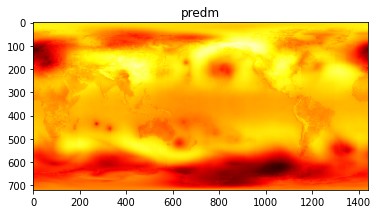

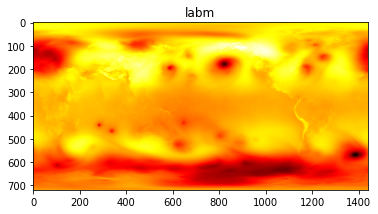

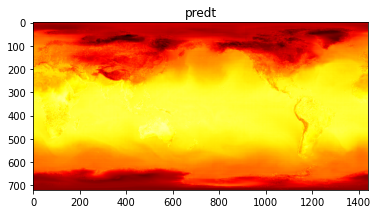

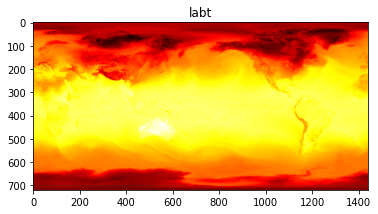

tensor([[[[ 0.5087, -1.1575, -2.1056,  ..., -1.2045, -2.0162, -1.9793],
          [ 2.1991,  3.2717,  0.4092,  ...,  3.2551,  0.7290, -1.6337],
          [-0.0451, -0.3699,  1.7972,  ..., -0.0207,  1.6085,  0.5402],
          ...,
          [ 0.5447,  0.9026, -0.9696,  ...,  1.0137, -0.7096, -0.3163],
          [ 0.9898,  0.6565,  0.6460,  ...,  0.7998,  0.6793, -0.0830],
          [ 0.1017, -0.0060,  0.8416,  ..., -0.1505,  0.6570, -1.2143]]]],
       grad_fn=<AddBackward0>)
2t loss: 7.701441973040346e-06
10u loss: 1.8595766277940129e-06
10v loss: 1.5711081005065353e-06
msl loss: 0.0006814990192651749
fire loss: 0.011081403496550716
lst loss: 0.016775857657194138
t loss: 3.5181292901143024e-07
u loss: 2.556826075306162e-07
v loss: 2.0548054635582957e-07
q loss: 2.1563403935164448e-14
z loss: 8.225379860959947e-05
Loss: 0.0120
2t pred min=218.88580322265625, max=315.31268310546875
2t lab min=219.07382202148438, max=314.0238342285156
10u pred min=-22.53702735900879, max=26.6653633117675

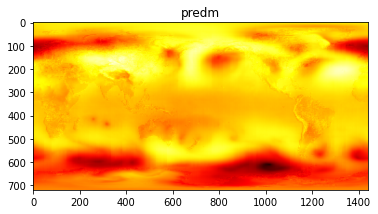

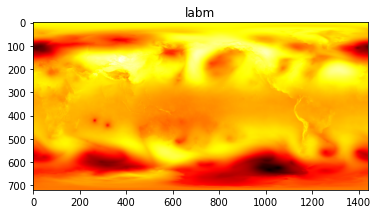

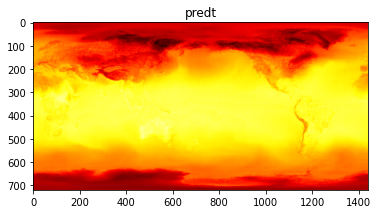

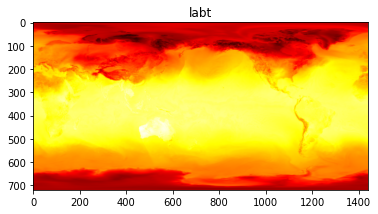

tensor([[[[-0.3729, -1.7899, -3.7484,  ..., -1.7259, -3.6495, -2.8853],
          [ 1.6573,  2.2796,  1.1950,  ...,  2.4009,  1.6041, -2.0641],
          [ 1.9828, -0.5856, -0.0961,  ..., -0.1478,  0.0206,  0.3366],
          ...,
          [ 0.5825,  0.7811, -0.8579,  ...,  0.8578, -0.5987, -0.5716],
          [ 0.9523,  0.8038,  0.5324,  ...,  0.9747,  0.5053, -0.2608],
          [-0.0909,  0.0790,  0.7827,  ..., -0.0664,  0.5781, -1.0777]]]],
       grad_fn=<AddBackward0>)
2t loss: 6.299394954112358e-06
10u loss: 1.8649838011697284e-06
10v loss: 1.6329903473888407e-06
msl loss: 0.0006608316907659173
fire loss: 0.01115023893164941
lst loss: 0.01486720610409975
t loss: 2.5016888116624614e-07
u loss: 2.7199652663512097e-07
v loss: 2.282152280486116e-07
q loss: 2.5199636756630117e-14
z loss: 7.472043216694146e-05
Loss: 0.0119
2t pred min=219.15911865234375, max=316.354736328125
2t lab min=219.23147583007812, max=318.4590148925781
10u pred min=-20.81294059753418, max=23.86574935913086
10

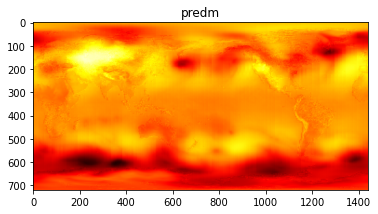

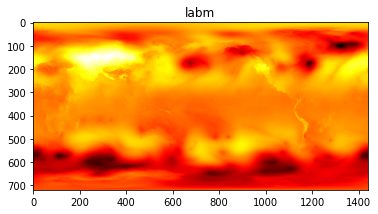

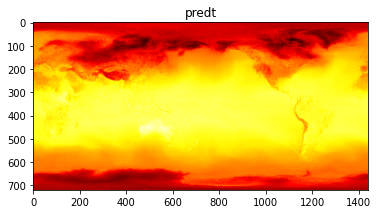

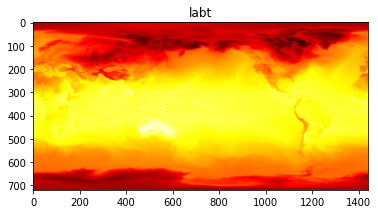

tensor([[[[-0.3252, -2.0520, -3.5851,  ..., -2.0135, -3.5490, -3.6654],
          [ 1.9464,  1.9049, -0.0196,  ...,  1.6066,  0.4704, -2.2544],
          [ 0.6418, -0.7151,  0.1751,  ..., -0.2824,  0.2051, -0.0872],
          ...,
          [ 0.5273,  0.8298, -0.8223,  ...,  0.9316, -0.6329, -0.5363],
          [ 0.8404,  0.6194,  0.6475,  ...,  0.8166,  0.5893, -0.2192],
          [-0.0543, -0.0401,  0.9123,  ..., -0.1959,  0.7294, -1.1695]]]],
       grad_fn=<AddBackward0>)
2t loss: 7.220417046482908e-06
10u loss: 1.7938347127710585e-06
10v loss: 1.5920744544928311e-06
msl loss: 0.000667212123516947
fire loss: 0.011282654464986908
lst loss: 0.012679808773100376
t loss: 2.3273716465155303e-07
u loss: 2.6599181524034066e-07
v loss: 2.2705729918470752e-07
q loss: 2.348640589465694e-14
z loss: 7.417453889502212e-05
Loss: 0.0120
2t pred min=218.0536651611328, max=317.0840759277344
2t lab min=218.5082244873047, max=315.0245056152344
10u pred min=-19.909629821777344, max=20.680025100708008


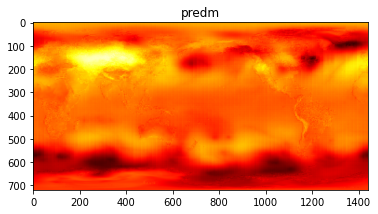

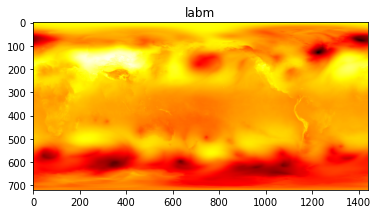

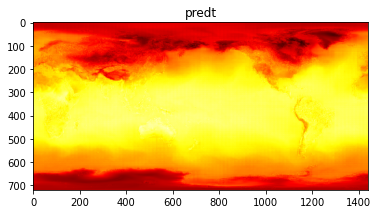

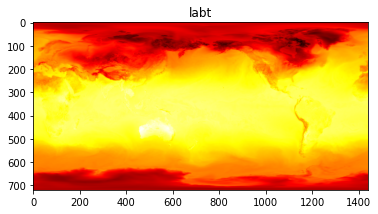

tensor([[[[ 0.2707, -2.0951, -1.9017,  ..., -1.8179, -1.7186, -3.3880],
          [ 1.5958,  1.3112,  0.1998,  ...,  1.7775,  1.0778, -3.4490],
          [-0.1703, -1.1099,  1.1500,  ..., -0.9864,  0.6863, -1.2808],
          ...,
          [ 0.0549,  1.1852, -0.0646,  ...,  0.6889, -0.0276, -0.4298],
          [ 1.5880,  0.4689,  0.3640,  ...,  0.7284,  0.9034, -0.7928],
          [ 1.4314, -0.5605,  0.7111,  ..., -0.5372,  0.3751, -2.0069]]]],
       grad_fn=<AddBackward0>)
2t loss: 9.28021745494334e-06
10u loss: 1.911526396725094e-06
10v loss: 1.6385516801165068e-06
msl loss: 0.0006743087433278561
fire loss: 0.011381753395969925
lst loss: 0.011250723153352737
t loss: 2.1191159760292066e-07
u loss: 2.752503860392608e-07
v loss: 2.162722836374087e-07
q loss: 2.4341815997759586e-14
z loss: 7.231369090732187e-05
Loss: 0.0120
2t pred min=219.62985229492188, max=317.5843505859375
2t lab min=220.1150360107422, max=320.2420959472656
10u pred min=-17.337705612182617, max=18.000516891479492
1

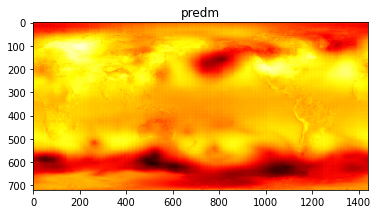

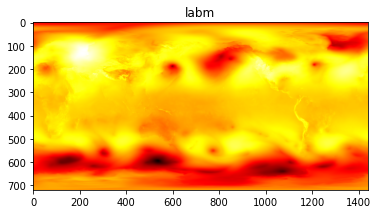

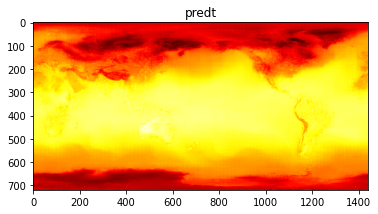

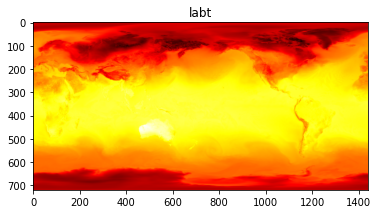

tensor([[[[-0.2000, -2.0203, -3.7622,  ..., -2.0030, -3.7382, -3.8180],
          [ 0.9888,  1.3430, -0.3316,  ...,  1.3712,  0.2931, -3.0878],
          [ 0.8248, -0.5746,  0.8201,  ..., -0.4084,  0.4073, -1.4804],
          ...,
          [-0.9890,  1.7115, -1.4304,  ...,  1.9572, -1.2128, -0.6518],
          [-0.3816,  0.4700,  2.4471,  ...,  0.9676,  1.8875,  0.8979],
          [ 0.7884,  0.1090,  0.5923,  ...,  0.3356,  0.4142, -1.3913]]]],
       grad_fn=<AddBackward0>)
2t loss: 7.667702448088676e-06
10u loss: 2.074139274554909e-06
10v loss: 1.7759938373274053e-06
msl loss: 0.000822671630885452
fire loss: 0.011674039556953219
lst loss: 0.009545903652906418
t loss: 2.2767974883208808e-07
u loss: 2.832139784914034e-07
v loss: 2.3615871214133222e-07
q loss: 2.498343667904114e-14
z loss: 8.991966751636937e-05
Loss: 0.0122
2t pred min=223.09451293945312, max=319.27093505859375
2t lab min=223.20895385742188, max=318.2664794921875
10u pred min=-17.734827041625977, max=17.199995040893555

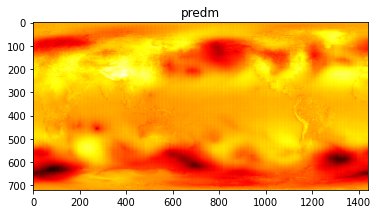

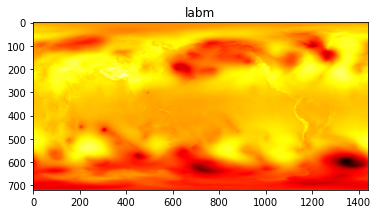

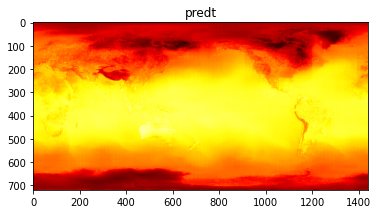

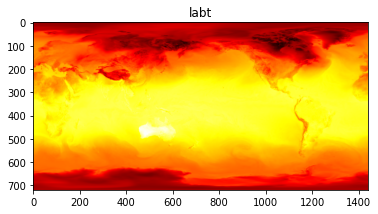

tensor([[[[-0.3432, -1.5996, -4.4431,  ..., -1.5722, -4.4327, -4.1770],
          [ 1.0081,  1.4347, -0.5481,  ...,  1.3675,  0.4198, -3.6111],
          [ 1.1019, -0.6301, -0.0697,  ..., -0.6325, -0.4282, -1.9951],
          ...,
          [ 0.6285,  0.7200, -0.7478,  ...,  0.8437, -0.5128, -0.7630],
          [ 0.7738,  0.8862,  0.6608,  ...,  1.1811,  0.5712, -0.4536],
          [-0.4836, -0.2747,  0.8583,  ..., -0.4405,  0.6830, -1.1206]]]],
       grad_fn=<AddBackward0>)
2t loss: 6.913220204296522e-06
10u loss: 1.7905360891745659e-06
10v loss: 1.5439023854924017e-06
msl loss: 0.0005693751736544073
fire loss: 0.01109851529463582
lst loss: 0.008244775235652924
t loss: 2.1528238391965715e-07
u loss: 2.7334803576195554e-07
v loss: 2.1900130775520665e-07
q loss: 2.397117132070005e-14
z loss: 7.068935519782826e-05
Loss: 0.0116
2t pred min=220.82347106933594, max=322.7315368652344
2t lab min=223.2664337158203, max=312.8671875
10u pred min=-17.348453521728516, max=19.17574691772461
10u la

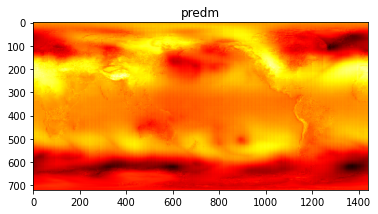

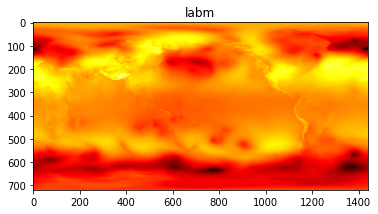

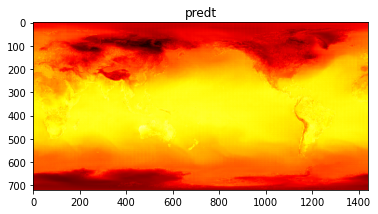

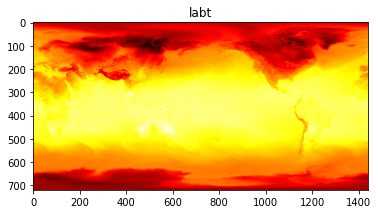

tensor([[[[-0.6330, -2.2121, -4.5423,  ..., -2.1788, -4.8862, -4.2710],
          [ 0.7229,  0.6273, -0.6502,  ...,  0.5409, -0.2082, -3.3710],
          [ 1.0428, -0.5988,  0.1162,  ..., -0.7082, -0.2063, -1.5111],
          ...,
          [ 0.4486,  0.8695, -0.8585,  ...,  1.0415, -0.5398, -0.6074],
          [ 0.9602,  0.5644,  0.4889,  ...,  0.6755,  0.4056, -0.2912],
          [-0.2587, -0.0594,  0.6262,  ..., -0.2752,  0.4920, -1.0566]]]],
       grad_fn=<AddBackward0>)
2t loss: 7.120233476598514e-06
10u loss: 1.7151568272311124e-06
10v loss: 1.484874815105286e-06
msl loss: 0.0005659852176904678
fire loss: 0.011254625801834511
lst loss: 0.007134940009564161
t loss: 2.0151006197011156e-07
u loss: 2.710070532430109e-07
v loss: 2.0800551681077195e-07
q loss: 2.317338317493322e-14
z loss: 6.920297164469957e-05
Loss: 0.0117
2t pred min=221.53240966796875, max=317.7583312988281
2t lab min=221.88247680664062, max=312.5915832519531
10u pred min=-16.31755256652832, max=20.552968978881836


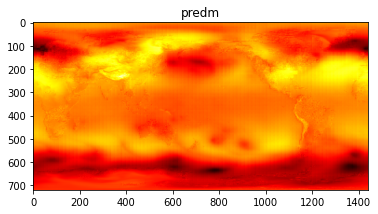

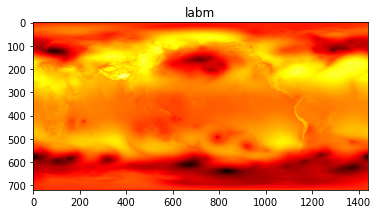

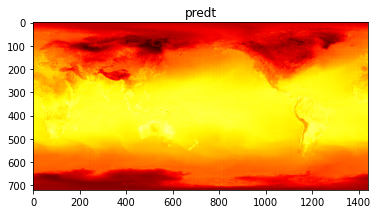

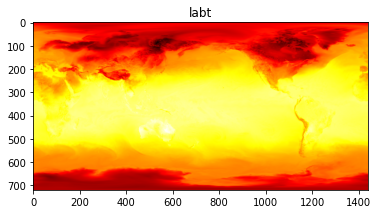

tensor([[[[-0.5522, -2.4796, -4.0755,  ..., -2.6274, -4.4011, -2.9605],
          [-0.1214,  0.3115, -1.3464,  ...,  0.0907, -0.6316, -3.6967],
          [ 1.2078, -1.4257, -0.0927,  ..., -1.3503,  0.0284, -2.1485],
          ...,
          [ 0.3153,  0.7932, -1.0874,  ...,  0.9360, -0.9317, -0.3462],
          [ 0.4320,  0.5708,  0.5389,  ...,  0.7332,  0.4803, -0.3154],
          [-0.1405,  0.0399,  0.5138,  ..., -0.1116,  0.3414, -1.2260]]]],
       grad_fn=<AddBackward0>)
2t loss: 8.349431482201908e-06
10u loss: 1.796843889678712e-06
10v loss: 1.7739139366312884e-06
msl loss: 0.0006468500359915197
fire loss: 0.011346305230827193
lst loss: 0.0061926934868097305
t loss: 2.2357464501965296e-07
u loss: 2.9407874535536394e-07
v loss: 2.297165195841444e-07
q loss: 2.414936672401162e-14
z loss: 7.48418242437765e-05
Loss: 0.0117
2t pred min=216.68479919433594, max=316.692626953125
2t lab min=218.15061950683594, max=320.263427734375
10u pred min=-13.913933753967285, max=16.991872787475586
1

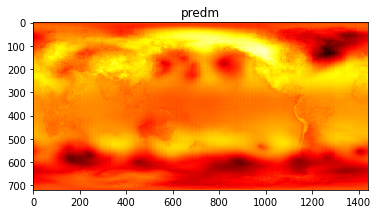

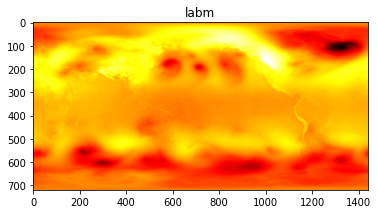

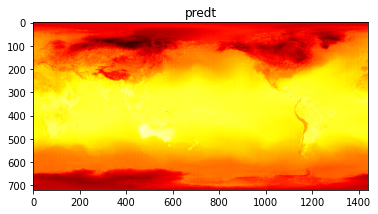

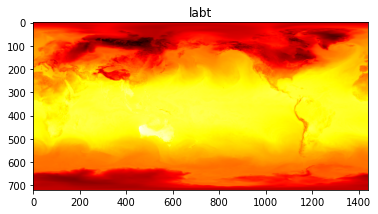

tensor([[[[-1.0220, -2.5313, -4.4869,  ..., -2.6195, -5.0826, -4.0375],
          [-0.3061,  0.1761, -1.2423,  ...,  0.4588, -1.0099, -3.6158],
          [ 0.9591, -1.0173, -0.5217,  ..., -1.3227, -0.5797, -2.4216],
          ...,
          [ 0.9112,  1.0505, -1.0483,  ...,  0.8105, -0.3212, -1.6243],
          [ 0.2647,  1.1861, -0.6506,  ...,  1.8449, -1.2953,  0.4875],
          [-1.0693, -0.4386, -0.7293,  ..., -0.9196, -1.0200,  0.1282]]]],
       grad_fn=<AddBackward0>)
2t loss: 8.761776371102314e-06
10u loss: 1.624953256396111e-06
10v loss: 1.4896229458827293e-06
msl loss: 0.000502362847328186
fire loss: 0.011297755025327412
lst loss: 0.005467930808663368
t loss: 1.8545847524364945e-07
u loss: 2.622506087845977e-07
v loss: 1.8798955636611936e-07
q loss: 2.4350044075809214e-14
z loss: 5.644081102218479e-05
Loss: 0.0116
2t pred min=226.22564697265625, max=322.10968017578125
2t lab min=226.66798400878906, max=315.8841247558594
10u pred min=-16.4697208404541, max=16.208410263061523


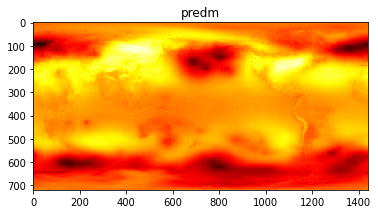

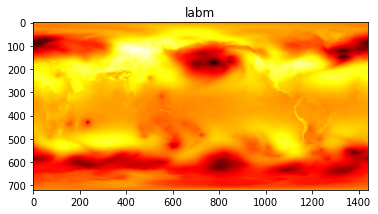

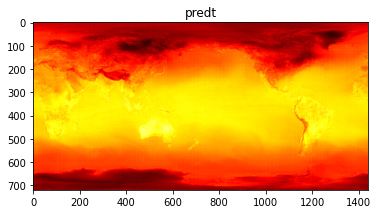

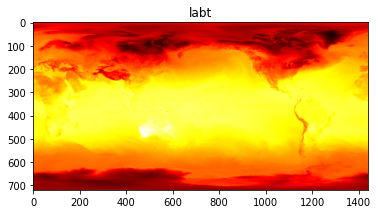

tensor([[[[-0.4885, -2.4254, -4.3565,  ..., -2.2714, -4.8423, -4.5482],
          [-0.6854, -0.3029, -2.0451,  ...,  0.5583, -1.5578, -3.2634],
          [ 0.3781, -1.3698, -0.5944,  ..., -1.1509, -0.5581, -1.9693],
          ...,
          [ 0.5229,  0.7747, -0.8399,  ...,  0.8996, -0.7663, -0.7253],
          [ 0.0868,  0.6213,  0.3480,  ...,  0.7276,  0.4269, -0.4618],
          [-0.7436,  0.2397,  0.3631,  ..., -0.1541,  0.2710, -0.9554]]]],
       grad_fn=<AddBackward0>)
2t loss: 8.66127902554581e-06
10u loss: 1.8743501186690992e-06
10v loss: 1.639518586671329e-06
msl loss: 0.0006484031910076737
fire loss: 0.011147347203065818
lst loss: 0.00483753252774477
t loss: 2.068636035801319e-07
u loss: 2.845497419912135e-07
v loss: 2.1469716671163042e-07
q loss: 2.4007924080281413e-14
z loss: 7.179765816545114e-05
Loss: 0.0115
2t pred min=219.79759216308594, max=317.267578125
2t lab min=218.7352752685547, max=317.2967224121094
10u pred min=-18.392948150634766, max=16.241918563842773
10u la

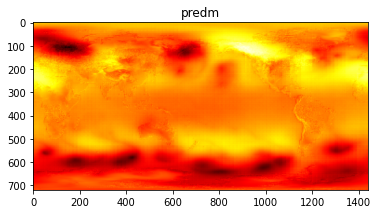

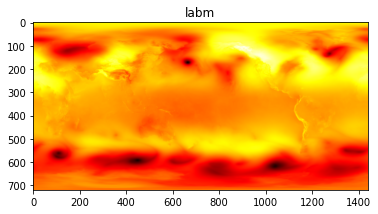

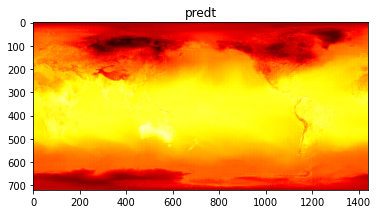

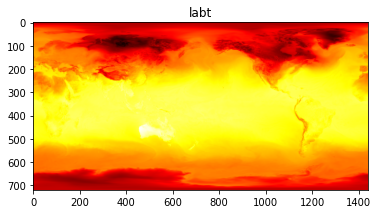

tensor([[[[-1.0259, -3.2016, -3.9296,  ..., -3.1245, -4.1280, -4.6755],
          [-1.5162, -0.4680, -2.3624,  ...,  0.1271, -1.8378, -3.9014],
          [ 0.3425, -1.7756, -1.0772,  ..., -1.9435, -1.0698, -2.6185],
          ...,
          [ 0.5358,  0.8716, -1.2019,  ...,  0.9826, -0.9946, -0.5930],
          [ 0.5204,  0.6467,  0.4047,  ...,  0.9137,  0.3749, -0.5239],
          [-0.4074, -0.0457,  0.3800,  ..., -0.2126,  0.1843, -1.1109]]]],
       grad_fn=<AddBackward0>)
2t loss: 7.83945415605558e-06
10u loss: 1.823286197577545e-06
10v loss: 1.882306719380722e-06
msl loss: 0.0006110039539635181
fire loss: 0.011278251684669808
lst loss: 0.004598495550453663
t loss: 2.115112636147387e-07
u loss: 2.8610386948457744e-07
v loss: 2.256973345993174e-07
q loss: 2.5327894485503363e-14
z loss: 7.056187314447016e-05
Loss: 0.0116
2t pred min=218.6422119140625, max=319.32916259765625
2t lab min=220.56298828125, max=318.69146728515625
10u pred min=-14.00517749786377, max=19.6678524017334
10u la

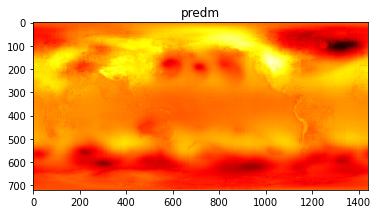

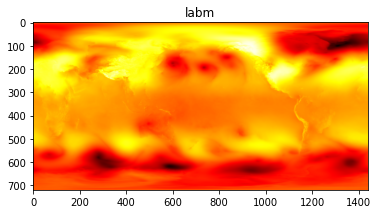

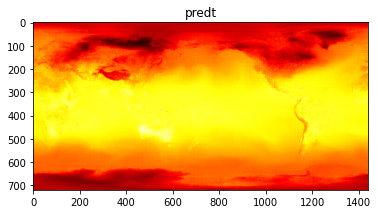

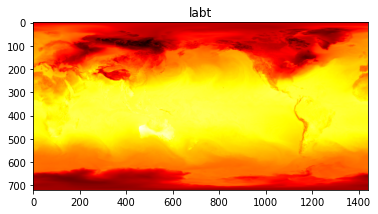

tensor([[[[-1.6694, -3.5903, -4.6258,  ..., -3.5829, -4.8869, -4.5250],
          [-1.7747, -0.8648, -2.5872,  ..., -0.3603, -2.1203, -3.4451],
          [ 0.5901, -1.6760, -1.5561,  ..., -2.2399, -1.4740, -2.6497],
          ...,
          [ 0.3689,  0.9433, -1.3725,  ...,  1.0790, -0.6300, -0.8805],
          [ 0.2306,  0.8612, -1.4095,  ...,  0.3862, -0.5104, -0.2372],
          [-0.7506, -0.1781, -0.5146,  ..., -0.3977, -0.2140, -1.0459]]]],
       grad_fn=<AddBackward0>)
2t loss: 6.4224577727145515e-06
10u loss: 1.9463059288682416e-06
10v loss: 1.8884114751926973e-06
msl loss: 0.0006525398348458111
fire loss: 0.010588132399985474
lst loss: 0.004237168002873659
t loss: 1.9580822652187635e-07
u loss: 2.821291218424449e-07
v loss: 2.2003882804710884e-07
q loss: 2.555225996070387e-14
z loss: 7.357427239185199e-05
Loss: 0.0109
2t pred min=225.59274291992188, max=317.18408203125
2t lab min=222.50953674316406, max=321.1513671875
10u pred min=-15.136392593383789, max=20.146923065185547
10

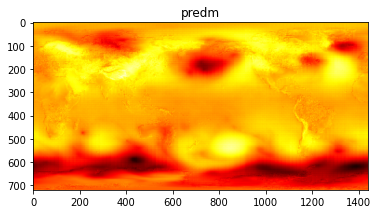

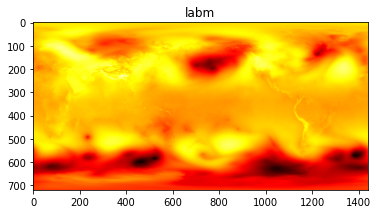

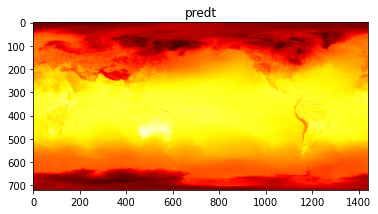

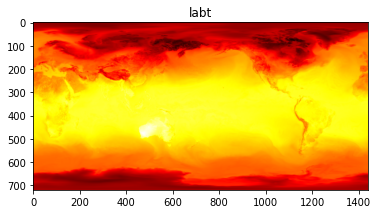

tensor([[[[-1.5471, -3.1383, -4.5130,  ..., -3.1413, -4.5898, -4.8458],
          [-1.6520, -1.1168, -3.4816,  ..., -0.4917, -3.0215, -2.9065],
          [-0.8713, -1.8947, -1.5141,  ..., -2.1445, -1.6873, -2.7801],
          ...,
          [ 0.3975,  0.7728, -1.0939,  ...,  0.8849, -0.8758, -0.7158],
          [ 0.7804,  0.4684,  0.2802,  ...,  0.6993,  0.3371, -0.4077],
          [-0.4138, -0.2559,  0.4245,  ..., -0.4532,  0.2016, -1.1459]]]],
       grad_fn=<AddBackward0>)
2t loss: 5.5815894484112505e-06
10u loss: 1.9043922065975494e-06
10v loss: 1.9754279492190108e-06
msl loss: 0.000542260822840035
fire loss: 0.009573183820264279
lst loss: 0.0037813701201230288
t loss: 1.9526690664406487e-07
u loss: 2.5610768261685735e-07
v loss: 2.0942492540143576e-07
q loss: 2.5032010630434386e-14
z loss: 6.3187864725478e-05
Loss: 0.0098
2t pred min=221.98773193359375, max=315.9361572265625
2t lab min=219.72422790527344, max=314.185546875
10u pred min=-16.910625457763672, max=16.40618324279785
10

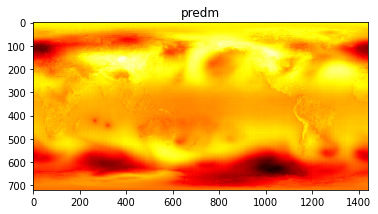

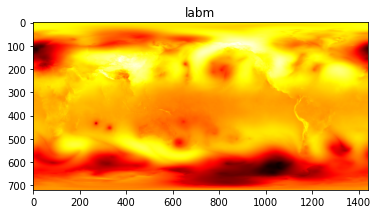

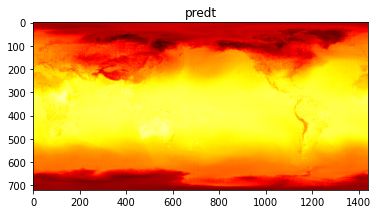

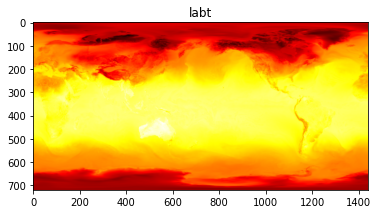

tensor([[[[-1.7572, -3.1315, -4.2968,  ..., -3.2016, -4.5642, -4.4194],
          [-2.1057, -0.8966, -3.2810,  ..., -0.4991, -2.7057, -3.0975],
          [-0.8800, -2.0030, -1.5034,  ..., -2.2983, -2.0510, -3.0301],
          ...,
          [-0.7070,  0.4057, -0.8466,  ...,  0.1217, -0.7626, -2.0243],
          [-0.1452, -0.5320, -1.1209,  ...,  0.1864, -1.3883, -0.7463],
          [-0.8233, -0.6660, -0.8044,  ..., -0.7330, -1.0719, -1.2229]]]],
       grad_fn=<AddBackward0>)
2t loss: 5.667016466759378e-06
10u loss: 1.9774945485551143e-06
10v loss: 1.994476861000294e-06
msl loss: 0.000598370039369911
fire loss: 0.009249306177616502
lst loss: 0.003735343227162957
t loss: 1.9230805037295795e-07
u loss: 2.6567920485831564e-07
v loss: 2.188570249472832e-07
q loss: 2.424058539616733e-14
z loss: 6.819109694333747e-05
Loss: 0.0095
2t pred min=226.86465454101562, max=315.6567077636719
2t lab min=225.05592346191406, max=318.4461364746094
10u pred min=-16.48673439025879, max=19.82393455505371
10

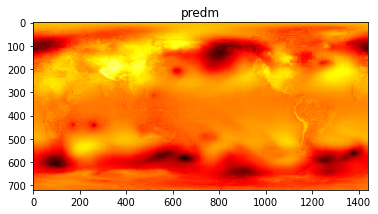

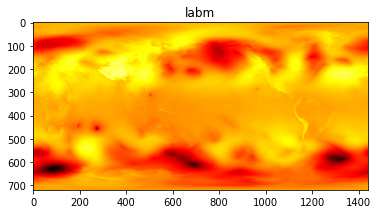

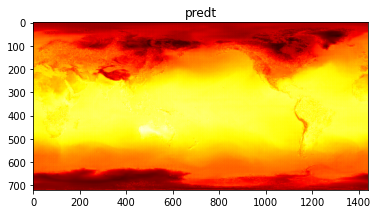

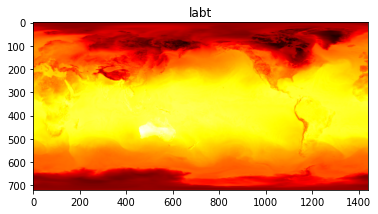

tensor([[[[-2.1188, -3.1164, -3.1952,  ..., -2.8373, -3.2399, -3.9024],
          [-2.8122, -1.2230, -2.5076,  ..., -0.4675, -2.2996, -3.8761],
          [-0.8971, -1.9618, -2.1949,  ..., -2.1200, -2.3893, -3.7535],
          ...,
          [ 0.3339,  0.4815, -1.0982,  ...,  0.6429, -0.8963, -0.6349],
          [ 0.5089,  0.4125,  0.4458,  ...,  0.6921,  0.4447, -0.5264],
          [-0.8157, -0.0695,  0.2380,  ..., -0.1753,  0.0645, -1.1507]]]],
       grad_fn=<AddBackward0>)
2t loss: 5.490998773893807e-06
10u loss: 2.0861459688603645e-06
10v loss: 1.8673393924473203e-06
msl loss: 0.0006119258468970656
fire loss: 0.009014370759931436
lst loss: 0.003634838853031397
t loss: 2.038678417193296e-07
u loss: 2.9090190878378053e-07
v loss: 2.084882027020285e-07
q loss: 2.4230681886948033e-14
z loss: 7.595903298351914e-05
Loss: 0.0093
2t pred min=221.21206665039062, max=317.7652893066406
2t lab min=221.48439025878906, max=316.9031982421875
10u pred min=-16.75703239440918, max=15.429834365844727

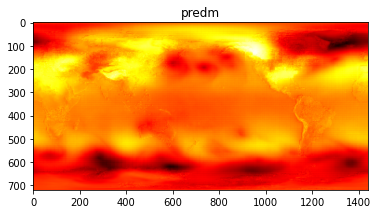

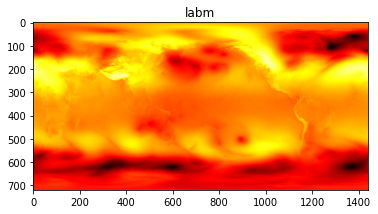

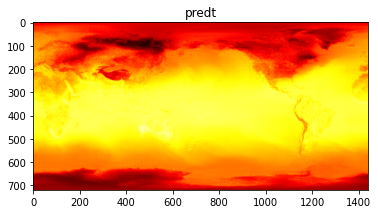

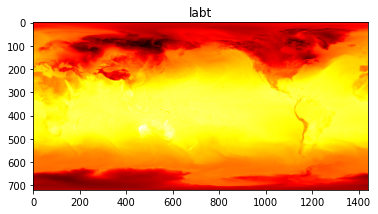

tensor([[[[-2.3843e+00, -2.9890e+00, -4.2118e+00,  ..., -2.9816e+00,
           -4.5253e+00, -4.3823e+00],
          [-2.1494e+00, -1.3870e+00, -2.8358e+00,  ..., -6.1993e-01,
           -2.4577e+00, -3.1295e+00],
          [-9.2279e-01, -2.1931e+00, -2.3217e+00,  ..., -2.3088e+00,
           -2.9451e+00, -3.2396e+00],
          ...,
          [-5.4941e-01,  6.9007e-01, -1.2238e+00,  ...,  5.0111e-01,
           -7.5004e-01, -2.3142e+00],
          [-5.5421e-01,  2.2017e-01, -1.8190e+00,  ...,  6.0361e-01,
           -1.7687e+00, -6.0467e-02],
          [-1.5358e-01, -9.2974e-01, -6.5160e-01,  ..., -8.8616e-01,
           -1.2672e+00, -2.8610e-03]]]], grad_fn=<AddBackward0>)
2t loss: 6.362691237882245e-06
10u loss: 2.032241127380985e-06
10v loss: 1.9065518017669092e-06
msl loss: 0.000560551998205483
fire loss: 0.00886643222238629
lst loss: 0.0036668262910097837
t loss: 1.843590098360437e-07
u loss: 2.670243475222378e-07
v loss: 2.0624904095711827e-07
q loss: 2.3860841891188388e-14
z lo

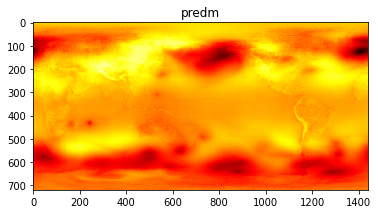

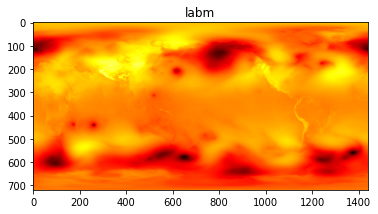

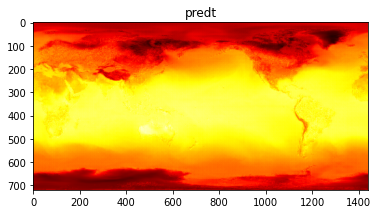

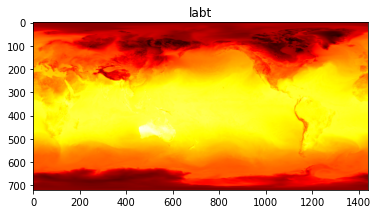

tensor([[[[-2.1493, -2.9825, -4.2430,  ..., -3.0305, -4.5123, -4.6758],
          [-2.6375, -0.7637, -4.0944,  ..., -0.0614, -3.6905, -2.9252],
          [-1.3386, -2.6128, -2.4874,  ..., -3.0144, -2.9728, -3.3586],
          ...,
          [-0.0318,  0.5291, -1.0828,  ...,  0.6841, -0.8819, -0.6856],
          [ 0.7351,  0.1247,  0.2462,  ...,  0.4120,  0.2099, -0.4503],
          [-0.5111, -0.0671,  0.3080,  ..., -0.2288,  0.0707, -1.3453]]]],
       grad_fn=<AddBackward0>)
2t loss: 6.726795163558563e-06
10u loss: 1.9987405721622054e-06
10v loss: 1.8477891217116849e-06
msl loss: 0.000563361681997776
fire loss: 0.008487551298716894
lst loss: 0.0034239040687680244
t loss: 1.968762859405615e-07
u loss: 2.611566856103309e-07
v loss: 2.1095600288845162e-07
q loss: 2.411231072663514e-14
z loss: 6.410440255422145e-05
Loss: 0.0087
2t pred min=218.38890075683594, max=315.927734375
2t lab min=219.67823791503906, max=313.38189697265625
10u pred min=-16.184144973754883, max=15.070236206054688
10

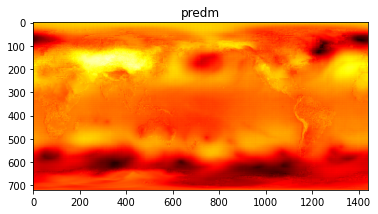

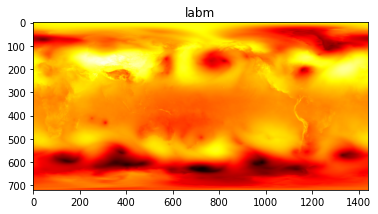

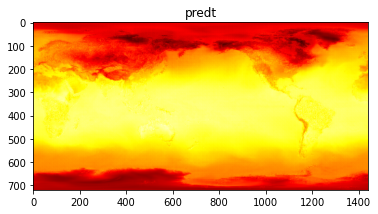

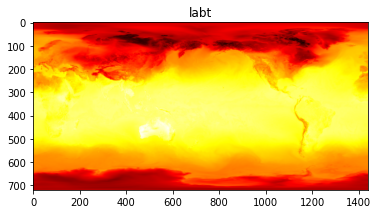

tensor([[[[-3.0710, -3.5565, -4.2893,  ..., -3.5788, -4.4322, -4.3297],
          [-2.8514, -1.0556, -2.6322,  ..., -0.3710, -2.2904, -4.2288],
          [-1.4116, -1.9054, -2.5824,  ..., -2.2435, -3.1092, -3.9932],
          ...,
          [-0.0442,  0.2541, -1.1183,  ...,  0.4950, -0.9579, -1.6104],
          [ 0.5209, -0.3341,  0.3180,  ...,  0.6782, -1.0723, -0.7368],
          [-0.7691, -0.1348,  0.1075,  ..., -0.3609, -1.0460, -0.9659]]]],
       grad_fn=<AddBackward0>)
2t loss: 6.563290753547335e-06
10u loss: 1.772058794813347e-06
10v loss: 1.6301256664519315e-06
msl loss: 0.00047075343900360167
fire loss: 0.008263577135382456
lst loss: 0.0033918539993464947
t loss: 1.7559071352479805e-07
u loss: 2.5978536655202333e-07
v loss: 1.879377151681183e-07
q loss: 2.3873593125176354e-14
z loss: 5.4249536333372816e-05
Loss: 0.0085
2t pred min=228.7288818359375, max=315.88885498046875
2t lab min=228.81222534179688, max=316.6225280761719
10u pred min=-12.329811096191406, max=17.96944808959

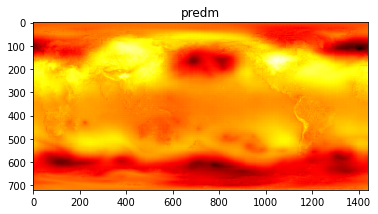

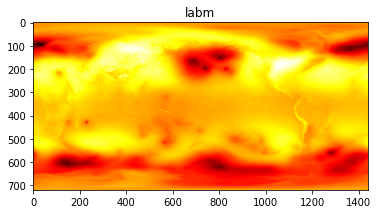

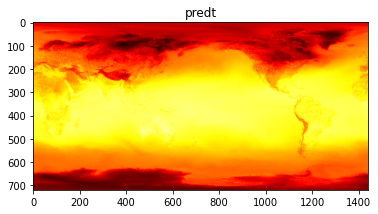

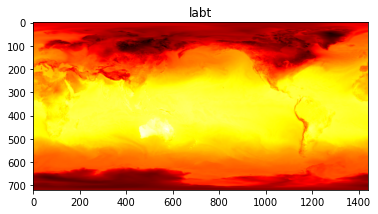

tensor([[[[-2.8689, -3.4358, -4.5496,  ..., -3.5172, -4.5483, -4.2908],
          [-2.3025, -1.5271, -3.3042,  ..., -0.8140, -2.6977, -4.0116],
          [-1.5681, -2.4328, -2.9621,  ..., -2.6198, -3.3469, -3.4593],
          ...,
          [-0.3815,  0.6803, -1.3994,  ...,  0.4330, -1.3989, -2.1931],
          [-0.6158, -0.1337, -2.2185,  ...,  0.3427, -2.4228,  0.0264],
          [ 0.0467, -0.9299, -1.0443,  ..., -1.1985, -1.0799, -0.3215]]]],
       grad_fn=<AddBackward0>)
2t loss: 6.364245109580224e-06
10u loss: 1.727224685055262e-06
10v loss: 1.629801204217074e-06
msl loss: 0.0005223331972956657
fire loss: 0.008639919523143299
lst loss: 0.0032555307261645794
t loss: 1.7525350415326102e-07
u loss: 2.511864920506923e-07
v loss: 1.8908335164269374e-07
q loss: 2.2950698213100064e-14
z loss: 5.613100802293047e-05
Loss: 0.0089
2t pred min=229.02369689941406, max=317.4889221191406
2t lab min=227.72654724121094, max=316.7153625488281
10u pred min=-13.723731994628906, max=16.74616241455078

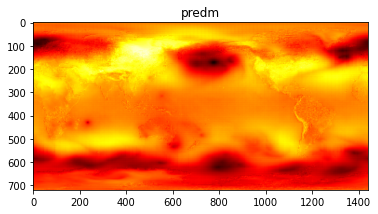

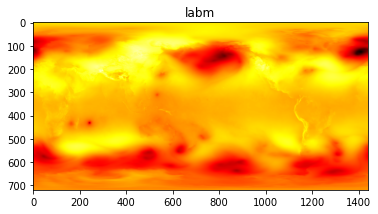

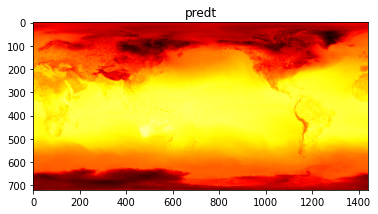

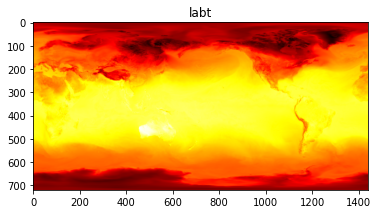

tensor([[[[-2.8669, -3.9413, -4.6755,  ..., -3.8920, -4.8776, -4.4077],
          [-2.0557, -1.9071, -4.0012,  ..., -1.0722, -3.5546, -3.7136],
          [-1.9276, -2.8332, -2.9070,  ..., -3.0367, -3.0284, -3.2551],
          ...,
          [ 0.0154,  0.3262, -1.1217,  ...,  0.5263, -1.0300, -0.2287],
          [ 0.4301, -0.0746,  0.4825,  ...,  0.1445,  0.4724, -0.4802],
          [-0.4847,  0.1461,  0.0776,  ...,  0.0166, -0.1528, -1.6568]]]],
       grad_fn=<AddBackward0>)
2t loss: 6.505860255856533e-06
10u loss: 1.8575759668237879e-06
10v loss: 1.6760217249611742e-06
msl loss: 0.0006578243337571621
fire loss: 0.008239821206226539
lst loss: 0.0030346757266670465
t loss: 2.0206950068768492e-07
u loss: 2.8716647193505196e-07
v loss: 2.190371617416531e-07
q loss: 2.4539759127203443e-14
z loss: 7.086389814503491e-05
Loss: 0.0085
2t pred min=220.1883544921875, max=314.87811279296875
2t lab min=216.5613555908203, max=318.4778137207031
10u pred min=-16.0989990234375, max=17.16106605529785


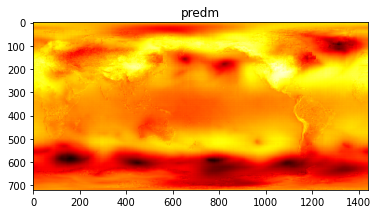

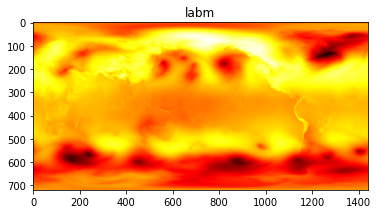

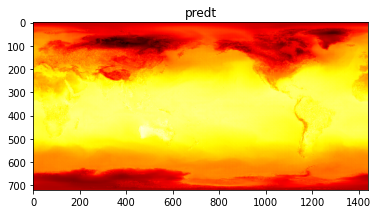

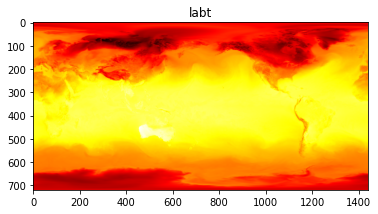

tensor([[[[-3.5171, -4.3512, -3.9154,  ..., -4.2333, -4.1212, -3.5717],
          [-2.5609, -2.9010, -3.5174,  ..., -2.2304, -2.7587, -5.1625],
          [-1.8555, -2.5238, -2.5455,  ..., -2.7296, -2.7420, -3.8791],
          ...,
          [-0.8824, -0.3839, -2.3278,  ..., -0.0613, -1.8502, -0.9825],
          [-0.2996, -1.6118,  0.5413,  ..., -1.2348,  0.3958, -0.9185],
          [-1.6546, -0.5015, -0.5964,  ..., -0.5255, -0.4973, -1.8234]]]],
       grad_fn=<AddBackward0>)
2t loss: 5.283165592118166e-06
10u loss: 1.7294519238930661e-06
10v loss: 1.636983824937488e-06
msl loss: 0.0006271835882216692
fire loss: 0.008410677631618506
lst loss: 0.0030021679122000933
t loss: 1.8691474679144449e-07
u loss: 2.7673857516674616e-07
v loss: 2.10157764968244e-07
q loss: 2.4465557346958072e-14
z loss: 6.814231892349198e-05
Loss: 0.0086
2t pred min=223.43594360351562, max=315.5954284667969
2t lab min=217.18035888671875, max=318.3951721191406
10u pred min=-14.799788475036621, max=16.04889106750488

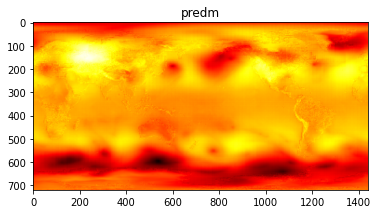

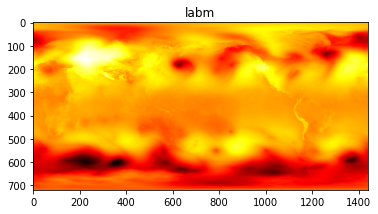

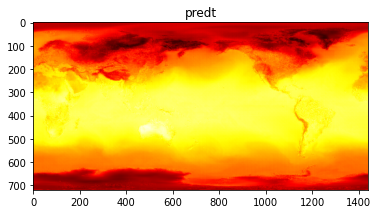

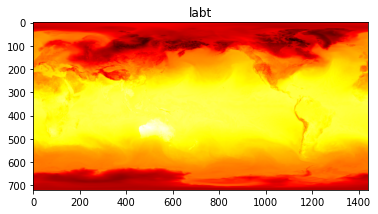

Epoch [1/1], Loss: 0.0086


In [30]:
# training 
model.train()
model.configure_activation_checkpointing()
optimizer = optim.AdamW(model.parameters(), lr=4e-5, weight_decay=5e-6)
# scaler = torch.cuda.amp.GradScaler() #
# scaler = torch.amp.GradScaler('cuda') #

ctr = 1
num_epochs = 1

# with torch.cuda.device('cuda'):
#     torch.cuda.empty_cache()
# torch.cuda.empty_cache()
for epoch in range(num_epochs):  # Loop over epochs
    # model.train()  # Set model to training mode
    for batch in dataloader:  # Iterate over batches
        # Unpack the batch
        features, labels = batch  # Ensure your Dataset and collate function return the right format
        # Move data to the appropriate device
        # features = {key: val.to(device) for key, val in features.items()}  # For dict-based features
        # plt.imshow(features.surf_vars['10v'][0][0, :, :].squeeze().cpu().numpy(), cmap="hot")
        # plt.title("feature")
        # plt.show()
        labels = labels.to(device)
        features = features.to(device)
        # print(features.surf_vars["lst"])
        # print(features)
        
        optimizer.zero_grad()  # Zero the gradients

        # with torch.cuda.amp.autocast():
        # with torch.amp.autocast('cuda'):
            # Forward pass
            # outputs = model(features)
        pred = model.forward(features)
        print(pred.surf_vars["fire"])
        # print(labels.surf_vars["fire"])
        # pred is already on gpu 
        # pred = pred.to(device)[
        # print(features)
        # Compute the loss
        loss = loss_func(labels,pred)
        print(f"Loss: {loss.item():.4f}")

        # print("msl pred min/max:", pred.surf_vars["msl"].min().detach().cpu().item(), pred.surf_vars["msl"].max().detach().cpu().item())
        # print("msl target min/max:", labels.surf_vars["msl"].min().detach().cpu().item(), labels.surf_vars["msl"].max().detach().cpu().item())
        # print("lst pred min/max:", pred.surf_vars["lst"].min().detach().cpu().item(), pred.surf_vars["lst"].max().detach().cpu().item())
        # print("lst target min/max:", labels.surf_vars["lst"].min().detach().cpu().item(), labels.surf_vars["lst"].max().detach().cpu().item())
        # print("z pred min/max:", pred.atmos_vars["z"].min().detach().cpu().item(), pred.atmos_vars["z"].max().detach().cpu().item())
        # print("z target min/max:", labels.atmos_vars["z"].min().detach().cpu().item(), labels.atmos_vars["z"].max().detach().cpu().item())

        # print("msl pred min/max:", pred.surf_vars["msl"].min(), pred.surf_vars["msl"].max())
        # print("msl target min/max:", labels.surf_vars["msl"].min(), labels.surf_vars["msl"].max())
        # print("lst pred min/max:", pred.surf_vars["lst"].min(), pred.surf_vars["lst"].max())
        # print("lst target min/max:", labels.surf_vars["lst"].min(), labels.surf_vars["lst"].max())
        # print("z pred min/max:", pred.atmos_vars["z"].min(), pred.atmos_vars["z"].max())
        # print("z target min/max:", labels.atmos_vars["z"].min(), labels.atmos_vars["z"].max())

        for key in pred.surf_vars.keys():
            print(f"{key} pred min={pred.surf_vars[key].min().item()}, max={pred.surf_vars[key].max().item()}")
            print(f"{key} lab min={labels.surf_vars[key].min().item()}, max={labels.surf_vars[key].max().item()}")


        
        # Backward pass and optimization
        loss.backward()  # Backpropagate  nan occurs here 
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5) ######## importnat line 

        # gradient flow testing
        # for name, param in model.named_parameters():
        #     if param.grad is not None:
        #         grad_norm = param.grad.norm().item()
        #         print(f"{name} grad norm: {grad_norm}")
        #     else:
        #         print(f"{name} has no gradients")

        # more grad flow testing
        # for name, param in model.named_parameters():
        #     if "weight" in name:
        #         param.data = torch.clamp(param.data, min=-1e8, max=1e8)


        # optimizer.step()  # Update the weights
        optimizer.step()
        # scaler.update()
        # torch.cuda.empty_cache()
        print(f"computed batch {ctr}")
        ctr += 1
        plt.imshow(pred.surf_vars['msl'].squeeze().detach().cpu().numpy(), cmap="hot")
        plt.title("predm")
        plt.show()
        
        plt.imshow(labels.surf_vars['msl'].squeeze().detach().cpu().numpy(), cmap="hot")
        plt.title("labm")
        plt.show()

        plt.imshow(pred.surf_vars['2t'].squeeze().detach().cpu().numpy(), cmap="hot")
        plt.title("predt")
        plt.show()
        
        plt.imshow(labels.surf_vars['2t'].squeeze().detach().cpu().numpy(), cmap="hot")
        plt.title("labt")
        plt.show()
        
        
        # Debug memory usage
        # print(f"Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
        # print(f"Reserved: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")
        with torch.cuda.device('cuda'):
            torch.cuda.empty_cache()
        # print(f"Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
        # print(f"Reserved: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")


        
        assert not torch.isnan(pred.surf_vars["msl"]).any(), "NaN in msl predictions!"
        assert not torch.isnan(labels.surf_vars["msl"]).any(), "NaN in msl targets!"
        # assert not torch.isinf(pred.surf_vars["msl"]).any(), "Inf in msl predictions!"
        assert not torch.isinf(labels.surf_vars["msl"]).any(), "Inf in msl targets!"
        
        assert not torch.isnan(pred.surf_vars["lst"]).any(), "NaN in lst predictions!"
        assert not torch.isnan(labels.surf_vars["lst"]).any(), "NaN in lst targets!"
        # assert not torch.isinf(pred.surf_vars["lst"]).any(), "Inf in msl predictions!"
        assert not torch.isinf(labels.surf_vars["lst"]).any(), "Inf in lst targets!"
        
        assert not torch.isnan(pred.atmos_vars["z"]).any(), "NaN in z predictions!"
        assert not torch.isnan(labels.atmos_vars["z"]).any(), "NaN in z targets!"
        # assert not torch.isinf(pred.atmos_vars["z"]).any(), "Inf in msl predictions!"
        assert not torch.isinf(labels.atmos_vars["z"]).any(), "Inf in z targets!"

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")
    

In [13]:
## freeing memory after restarting model

with torch.no_grad():
    torch.cuda.empty_cache()

import gc
torch.cuda.empty_cache()
gc.collect()

521

In [32]:
print("hi")

hi


In [33]:
torch.save(model.state_dict(), "goodloss.pth")

### see aws id for missing line
# bucket_name = 'globfire-gooddata'
# s3.upload_file("aurora_fire_weights.pth", bucket_name, "aurora_fire_weights.pth")

### some debug stuff (not important for runing)

In [ ]:
# model training 

model.train()
model.configure_activation_checkpointing()
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=5e-6)

model = model.to(device)
model.train()
model.configure_activation_checkpointing()
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

num_epochs = 1
torch.cuda.empty_cache()
for epoch in range(num_epochs):  # Loop over epochs
    # model.train()  # Set model to training mode
    for batch in dataloader:  # Iterate over batches
        # Unpack the batch
        features, labels = batch  # Ensure your Dataset and collate function return the right format
        # Move data to the appropriate device
        # features = {key: val.to(device) for key, val in features.items()}  # For dict-based features
        labels = labels.to(device)
        # features = features.to(device)

        # Forward pass
        # outputs = model(features)
        pred = model.forward(features)
        # pred is already on gpu 
        # pred = pred.to(device)[
        print(pred)
        # Compute the loss
        loss = loss_func(labels,pred)
        
        # Backward pass and optimization
        optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Backpropagate
        optimizer.step()  # Update the weights
        torch.cuda.empty_cache()
        print("computed first batch")

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")
    break

In [15]:
# model training 

import torch
import torch.nn as nn
import torch.optim as optim

model.train()
model.configure_activation_checkpointing()
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=5e-6)

model = model.to(device)
model.train()
model.configure_activation_checkpointing()
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

num_epochs = 1
torch.cuda.empty_cache()
for epoch in range(num_epochs):  # Loop over epochs
    # model.train()  # Set model to training mode
    for batch in dataloader:  # Iterate over batches
        # Unpack the batch
        features, labels = batch  # Ensure your Dataset and collate function return the right format
        # Move data to the appropriate device
        # features = {key: val.to(device) for key, val in features.items()}  # For dict-based features
        labels = labels.to(device)
        # features = features.to(device)

        # Forward pass
        # outputs = model(features)
        pred = model.forward(features)
        # pred is already on gpu 
        # pred = pred.to(device)
        print(pred)
        # Compute the loss
        loss = loss_func(labels,pred)
        
        # Backward pass and optimization
        optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Backpropagate
        optimizer.step()  # Update the weights
        torch.cuda.empty_cache()
        print("computed first batch")

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")
    break

Batch(surf_vars={'2t': tensor([[[[248.2111, 250.3261, 250.2283,  ..., 249.8091, 250.0388, 247.3506],
          [256.5222, 255.5726, 255.3369,  ..., 255.0719, 255.2536, 245.8392],
          [252.1862, 253.3263, 249.0282,  ..., 253.4009, 249.3633, 248.7849],
          ...,
          [243.7909, 243.7615, 243.8710,  ..., 243.7093, 243.9118, 244.1356],
          [244.0923, 243.9736, 244.1088,  ..., 243.8568, 243.9820, 244.0134],
          [243.9003, 243.9125, 243.7339,  ..., 243.9700, 243.8595, 243.8047]]]],
       device='cuda:0', grad_fn=<AddBackward0>), '10u': tensor([[[[  3.5809,   3.3212,   1.3584,  ...,   3.0293,   1.0162,   3.7811],
          [ -7.9823,  -7.5491,  -9.8704,  ...,  -7.3736,  -9.8940,  -7.1199],
          [ -4.5390,  -4.3756, -10.2827,  ...,  -4.1192, -10.1291,  -8.2069],
          ...,
          [ -3.3834,  -3.3105,  -3.2968,  ...,  -3.2817,  -3.2331,  -3.3291],
          [ -3.0977,  -3.0532,  -3.0555,  ...,  -3.1011,  -3.0014,  -3.0439],
          [ -2.4023,  -2.4306,

/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed first batch
Batch(surf_vars={'2t': tensor([[[[246.5566, 249.0670, 248.9123,  ..., 248.7042, 248.8638, 246.1772],
          [254.5370, 254.2614, 253.9191,  ..., 253.9032, 253.9358, 248.8828],
          [250.2312, 251.7356, 247.2331,  ..., 251.6860, 247.5735, 246.9567],
          ...,
          [245.6753, 245.1755, 245.6828,  ..., 246.0768, 246.3116, 246.4983],
          [247.3932, 246.8410, 247.1264,  ..., 246.4315, 246.4003, 246.4061],
          [245.2274, 245.0392, 245.4596,  ..., 246.7330, 246.5004, 246.3099]]]],
       device='cuda:0', grad_fn=<AddBackward0>), '10u': tensor([[[[  2.6317,   2.3470,   0.6036,  ...,   1.8345,   0.3006,   2.6186],
          [ -8.5061,  -7.9438, -10.3034,  ...,  -7.3911,  -9.7658,  -7.0160],
          [ -5.3238,  -5.0784, -10.9660,  ...,  -4.7888, -10.6551,  -8.6438],
          ...,
          [ -4.4275,  -4.4794,  -4.4256,  ...,  -3.8151,  -3.9774,  -4.1757],
          [ -3.8242,  -3.6514,  -3.3166,  ...,  -4.1819,  -4.0720,  -4.0007],
         

/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed first batch
Epoch [1/1], Loss: 0.0017


In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"
# !export PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:64 3.17 112

In [ ]:
print(os.getenv("PYTORCH_CUDA_ALLOC_CONF"))

In [ ]:
print(torch.cuda.memory_summary())

### predicting on new data

In [8]:
model = Aurora(
    use_lora=False,
    autocast=True,      # reduces memory usage
    surf_vars=("2t", "10u", "10v", "msl", "fire","lst"),
    static_vars=("lsm", "z", "slt"),
    atmos_vars=("z", "u", "v", "t", "q"),
)
# model = Aurora(
#     use_lora=False,
#     autocast=True,      # reduces memory usage
#     # surf_vars=("2t", "10u", "10v", "msl"),
#     surf_vars=("2t", "10u", "10v", "msl", "fire"),
#     static_vars=("lsm", "z", "slt"),
#     atmos_vars=("z", "u", "v", "t", "q"),
# )

# model.load_checkpoint("microsoft/aurora", "aurora-0.25-pretrained.ckpt", strict=False)
model.load_state_dict(torch.load("aurora_fire_weights_all.pth"), strict=False)
model = model.to("cuda")

/tmp/ipykernel_2457/1207869413.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("aurora_fire_weights_all.pth"), strict=False)


In [41]:
def compute_buffer_metrics(pred_fire, lab_fire, buffer_radius=2):
    """
    Compute precision and recall with buffer zones around true fires.
    Args:
        pred_fire: 2D array of predicted fires (shape [720, 1440]).
        lab_fire: 2D array of ground-truth fires (shape [720, 1440]).
        buffer_radius: Radius for buffer zones (default: 2).
    Returns:
        precision_buffer: Precision with buffer zones.
        recall_buffer: Recall with buffer zones.
    """
    # Dilate the ground-truth fire mask
    lab_fire_dilated = binary_dilation(lab_fire, iterations=buffer_radius)

    # True Positives (TP): Predicted fires within the buffer zone
    TP = np.logical_and(pred_fire == 1, lab_fire_dilated == 1).sum()
    
    # False Positives (FP): Predicted fires outside the buffer zone
    FP = np.logical_and(pred_fire == 1, lab_fire_dilated == 0).sum()
    
    # False Negatives (FN): True fires not covered by any prediction
    FN = np.logical_and(pred_fire == 0, lab_fire == 1).sum()

    # Precision and Recall
    precision_buffer = TP / (TP + FP) if (TP + FP) > 0 else 1.0
    recall_buffer = TP / (TP + FN) if (TP + FN) > 0 else 1.0

    return precision_buffer, recall_buffer

def compute_pr_auc(pred_fire_probs, lab_fire):
    """
    Compute Precision-Recall AUC using predicted probabilities.
    """
    precision, recall, _ = precision_recall_curve(lab_fire, pred_fire_probs)
    pr_auc = auc(recall, precision)
    return pr_auc

def compute_spatial_f1(precision_buffer, recall_buffer):
    """
    Compute F1-score using buffer-based precision and recall.
    """
    if (precision_buffer + recall_buffer) == 0:
        return 0.0
    return 2 * (precision_buffer * recall_buffer) / (precision_buffer + recall_buffer)


    

Accuracy: 0.9822
Precision: 0.0213
Recall: 0.0823
F1 Score: 0.0339
IoU: 0.0172
Precision (Buffer): 0.0554
Recall (Buffer): 0.1886
Precision-Recall AUC: 0.0536
Spatial F1-Score: 0.0856


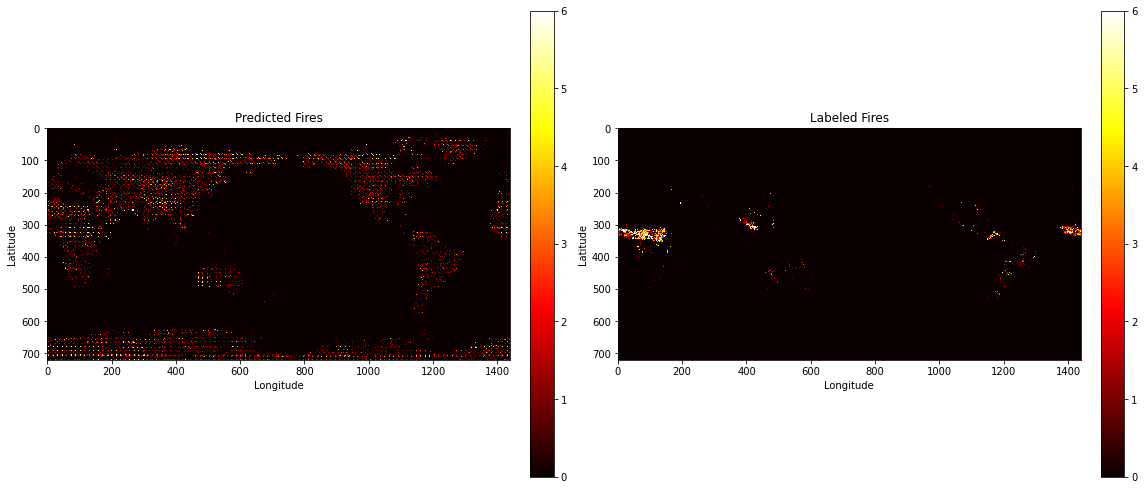

In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score, precision_recall_curve, auc
from scipy.ndimage import binary_dilation
import numpy as np
import matplotlib.pyplot as plt

# Initialize metrics
accuracy = 0
precision = 0
recall = 0
f1 = 0
iou = 0
precision_buffer = 0
recall_buffer = 0
pr_auc = 0
spatial_f1 = 0
total_samples = 0

threshold = 0.5
buffer_radius = 2  # Radius for buffer zones

# Initialize an array to hold the sum of predicted fires for visualization
pred_grid = np.zeros((720, 1440))
lab_grid = np.zeros((720, 1440))

model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient computations
    for batch in dataloader_test:
        features, labels = batch  # Ensure your Dataset and collate function return the right format
        labels = labels.to(device)
        features = features.to(device)
        
        pred = model.forward(features)

        # Reshape predictions and labels to 2D
        pred_fire = pred.surf_vars["fire"].cpu().numpy().reshape(720, 1440)
        pred_fire = np.nan_to_num(pred_fire, nan=0)
        pred_fire_binary = (pred_fire > threshold).astype(int)  # Binary predictions
        lab_fire = labels.surf_vars["fire"].cpu().numpy().reshape(720, 1440)

        # Add to grid for visualization
        pred_grid += pred_fire_binary
        lab_grid += lab_fire
        
        # Flatten predictions and labels for metric computation
        pred_fire_flat = pred_fire_binary.flatten()
        lab_fire_flat = lab_fire.flatten().astype(int)  # Ensure labels are integers

        # Compute standard metrics
        accuracy += accuracy_score(lab_fire_flat, pred_fire_flat)
        precision += precision_score(lab_fire_flat, pred_fire_flat, zero_division=1)
        recall += recall_score(lab_fire_flat, pred_fire_flat, zero_division=1)
        f1 += f1_score(lab_fire_flat, pred_fire_flat, zero_division=1)
        iou += jaccard_score(lab_fire_flat, pred_fire_flat)

        # Compute buffer-based metrics
        prec_buf, rec_buf = compute_buffer_metrics(pred_fire_binary, lab_fire, buffer_radius)
        precision_buffer += prec_buf
        recall_buffer += rec_buf

        # Compute Precision-Recall AUC
        pr_auc += compute_pr_auc(pred_fire_flat, lab_fire_flat)

        # Compute Spatial F1-score
        spatial_f1 += compute_spatial_f1(prec_buf, rec_buf)

        total_samples += 1

# Average metrics over all batches
accuracy /= total_samples
precision /= total_samples
recall /= total_samples
f1 /= total_samples
iou /= total_samples
precision_buffer /= total_samples
recall_buffer /= total_samples
pr_auc /= total_samples
spatial_f1 /= total_samples

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"IoU: {iou:.4f}")
print(f"Precision (Buffer): {precision_buffer:.4f}")
print(f"Recall (Buffer): {recall_buffer:.4f}")
print(f"Precision-Recall AUC: {pr_auc:.4f}")
print(f"Spatial F1-Score: {spatial_f1:.4f}")

# Plot predicted and labeled fires
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
im0 = axes[0].imshow(pred_grid, cmap='hot', interpolation='nearest')
axes[0].set_title('Predicted Fires')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(lab_grid, cmap='hot', interpolation='nearest')
axes[1].set_title('Labeled Fires')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

same code but with visalizaztions

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score

accuracy = 0
precision = 0
recall = 0
f1 = 0
iou = 0
total_samples = 0

threshold = 0.5 

# Initialize an array to hold the sum of predicted fires for visualization
pred_grid = np.zeros((720, 1440))
lab_grid = np.zeros((720, 1440))

model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient computations
    # for batch in dataloader_test:
    for batch in dataloader_test:        
        features, labels = batch  # Ensure your Dataset and collate function return the right format
        
        labels = labels.to(device)
        features = features.to(device)
        
        pred = model.forward(features)
        
        # flatten turns 720, 1440 into 1036800 
        pred_fire = pred.surf_vars["fire"].cpu().numpy().reshape(720, 1440)
        pred_fire = np.nan_to_num(pred_fire, nan=0)
        lab_fire = labels.surf_vars["fire"].cpu().numpy().reshape(720, 1440)

        # adding to grid
        pred_grid += pred_fire
        lab_grid += lab_fire

        # flattening fr fr
        pred_fire = pred_fire.flatten()
        lab_fire = lab_fire.flatten()

        
        pred_fire = (pred_fire > threshold).astype(int)
        lab_fire = (lab_fire > threshold).astype(int)

        # Compute metrics
        accuracy += accuracy_score(lab_fire, pred_fire)
        precision += precision_score(lab_fire, pred_fire, zero_division=1)
        recall += recall_score(lab_fire, pred_fire, zero_division=1)
        f1 += f1_score(lab_fire, pred_fire, zero_division=1)
        iou += jaccard_score(lab_fire, pred_fire)
        # total_samples += labels.size(0)
        total_samples += 1

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"IoU: {iou:.4f}")

in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem f

In [23]:
print(pred_grid)
print(lab_grid)

pred_grid_flat = (pred_grid > threshold).astype(int)
print(pred_grid_flat)

[[ 0.  1.  0. ...  2.  0. 68.]
 [ 0.  0.  5. ...  0.  6. 40.]
 [ 2. 31.  0. ... 37.  0. 73.]
 ...
 [ 1.  8.  3. ... 15.  3. 18.]
 [60.  1.  0. ...  3.  0. 59.]
 [41. 70.  1. ... 71.  3. 49.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0 1 0 ... 1 0 1]
 [0 0 1 ... 0 1 1]
 [1 1 0 ... 1 0 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 0 ... 1 0 1]
 [1 1 1 ... 1 1 1]]


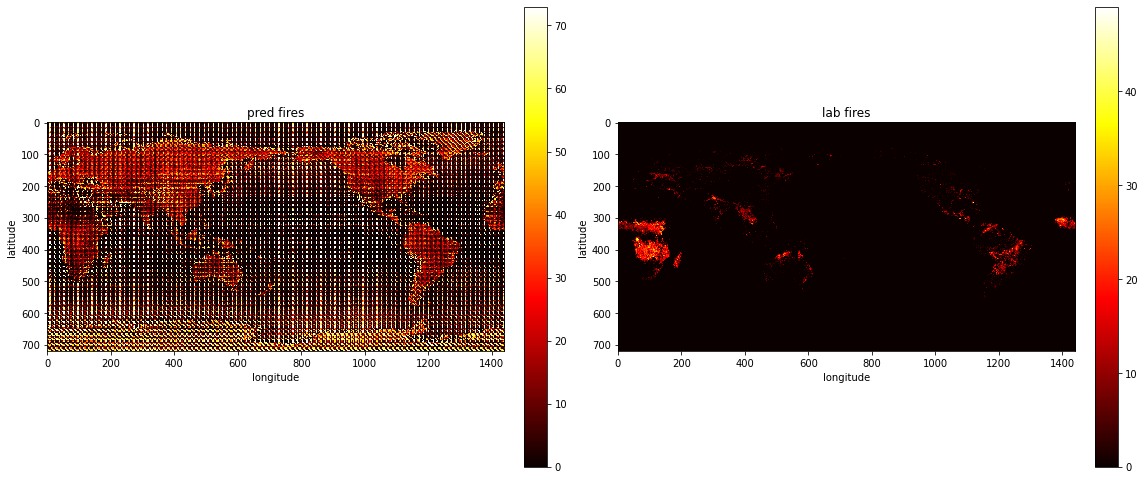

In [27]:

#plotting
fig, axes  = plt.subplots(1, 2, figsize = (16,8))
axes[0].imshow(pred_grid, cmap = 'hot', interpolation = 'nearest')
axes[0].set_title('pred fires')
axes[0].set_xlabel('longitude')
axes[0].set_ylabel('latitude')
axes[0].colorbar = fig.colorbar(axes[0].images[0], ax=axes[0], fraction=0.046, pad=0.04)

axes[1].imshow(lab_grid, cmap = 'hot', interpolation = 'nearest')
axes[1].set_title('lab fires')
axes[1].set_xlabel('longitude')
axes[1].set_ylabel('latitude')
axes[1].colorbar = fig.colorbar(axes[1].images[0], ax=axes[1], fraction=0.046, pad=0.04)


# plt.colorbar(label='Number of predictions')
plt.tight_layout()
plt.show()

In [11]:
##### import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score

# accuracy = {}
# precision = {}
# recall = {}
# f1 = {}
# iou = {}
# total_samples = 0

accuracy = 0
precision = 0
recall = 0
f1 = 0
iou = 0

threshold = 0.5 

# Initialize dictionaries to hold cumulative grids for each variable
pred_grids = {}
pred_grids_thresh = {}
lab_grids = {}

model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient computations
    for batch in dataloader_test:        
        features, labels = batch  # Ensure your Dataset and collate function return the right format
        
        labels = labels.to(device)
        features = features.to(device)
        
        pred = model.forward(features)
        
        # Iterate through all variables in surf_vars
        for var in pred.surf_vars.keys():
            # Initialize grids for each variable if not already done
            # if var not in pred_grids:
            #     pred_grids[var] = np.zeros((720, 1440))
            #     lab_grids[var] = np.zeros((720, 1440))
            #     accuracy[var] = 0
            #     precision[var] = 0
            #     recall[var] = 0
            #     f1[var] = 0
            #     iou[var] = 0

            # Reshape and threshold predictions and labels for the current variable
            pred_var = pred.surf_vars[var].cpu().numpy().reshape(720, 1440)
            pred_var = np.nan_to_num(pred_var, nan=0)
            
            lab_var = labels.surf_vars[var].cpu().numpy().reshape(720, 1440)

            # Accumulate for visualization
            pred_grids[var] += pred_var
            lab_grids[var] += lab_var

            if var == 'fire':
                pred_grids_thresh[var] += (pred_grids[var] > 0).astype(int)

                pred_fire = pred.surf_vars["fire"].cpu().numpy().flatten() 
                pred_fire = np.nan_to_num(pred_fire, nan=0)
                pred_fire = (pred_fire > 0).astype(int)    # equivalent to doing sigmoid with threshold of 0.5
                lab_fire = labels.surf_vars["fire"].cpu().numpy().flatten() 
                # lab_fire = (lab_fire > threshold).astype(int)  # this just converts float to int
                lab_fire = (lab_fire).astype(int)  # this just converts float to int

                accuracy += accuracy_score(lab_fire, pred_fire)
                precision += precision_score(lab_fire, pred_fire, zero_division=1)
                recall += recall_score(lab_fire, pred_fire, zero_division=1)
                f1 += f1_score(lab_fire, pred_fire, zero_division=1)
                iou += jaccard_score(lab_fire, pred_fire)
        

            # # Flatten for metrics calculation
            # pred_var_flat = pred_var.flatten()
            # lab_var_flat = lab_var.flatten()
            # pred_var = pred_var.astype(int)
            # lab_var = lab_var.astype(int)

            # # Compute metrics for the current variable
            # accuracy[var] += accuracy_score(lab_var_flat, pred_var_flat)
            # precision[var] += precision_score(lab_var_flat, pred_var_flat, zero_division=1)
            # recall[var] += recall_score(lab_var_flat, pred_var_flat, zero_division=1)
            # f1[var] += f1_score(lab_var_flat, pred_var_flat, zero_division=1)
            # iou[var] += jaccard_score(lab_var_flat, pred_var_flat)
        
        total_samples += 1
        # print("total samples", total_samples)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"IoU: {iou:.4f}")
# # Compute average metrics for each variable
# for var in pred_grids.keys():
#     accuracy[var] /= total_samples
#     precision[var] /= total_samples
#     recall[var] /= total_samples
#     f1[var] /= total_samples
#     iou[var] /= total_samples
#     print(f"Variable: {var}")
#     print(f"  Accuracy: {accuracy[var]:.4f}")
#     print(f"  Precision: {precision[var]:.4f}")
#     print(f"  Recall: {recall[var]:.4f}")
#     print(f"  F1 Score: {f1[var]:.4f}")
#     print(f"  IoU: {iou[var]:.4f}")

# Plotting for each variable using subplots
for var in pred_grids.keys():
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Plot predicted grid for the current variable
    axes[0].imshow(pred_grids[var], cmap='hot', interpolation='nearest')
    axes[0].set_title(f'Predicted {var} Overlay')
    axes[0].set_xlabel('Longitude')
    axes[0].set_ylabel('Latitude')
    axes[0].colorbar = fig.colorbar(axes[0].images[0], ax=axes[0], fraction=0.046, pad=0.04)

    # Plot labeled grid for the current variable
    axes[1].imshow(lab_grids[var], cmap='hot', interpolation='nearest')
    axes[1].set_title(f'Labeled {var} Overlay')
    axes[1].set_xlabel('Longitude')
    axes[1].set_ylabel('Latitude')
    axes[1].colorbar = fig.colorbar(axes[1].images[0], ax=axes[1], fraction=0.046, pad=0.04)

    # Show the plots
    plt.tight_layout()
    plt.show()

    
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
# Plot predicted grid for the current variable
axes[0].imshow(pred_grids_thresh['fire'], cmap='hot', interpolation='nearest')
axes[0].set_title(f'Predicted fire Overlay')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].colorbar = fig.colorbar(axes[0].images[0], ax=axes[0], fraction=0.046, pad=0.04)

# Plot labeled grid for the current variable
axes[1].imshow(lab_grids[var], cmap='hot', interpolation='nearest')
axes[1].set_title(f'Labeled {var} Overlay')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].colorbar = fig.colorbar(axes[1].images[0], ax=axes[1], fraction=0.046, pad=0.04)

# Show the plots
plt.tight_layout()
plt.show()

KeyError: '2t'

In [29]:
# Create a dictionary to hold the data arrays for each variable
data_dict = {}

for var in pred_grids.keys():
    # Create DataArrays for pred and lab grids
    pred_da = xr.DataArray(
        pred_grids[var], 
        dims=["lat", "lon"], 
        coords={"lat": np.arange(720), "lon": np.arange(1440)},
        name=f"pred_{var}"
    )
    
    lab_da = xr.DataArray(
        lab_grids[var], 
        dims=["lat", "lon"], 
        coords={"lat": np.arange(720), "lon": np.arange(1440)},
        name=f"lab_{var}"
    )
    
    # Add them to the dictionary
    data_dict[f"pred_{var}"] = pred_da
    data_dict[f"lab_{var}"] = lab_da

# Combine all DataArrays into a single Dataset
dataset = xr.Dataset(data_dict)

# Save the dataset to a NetCDF file
output_path = "preliminary_aurora_results.nc"
dataset.to_netcdf(output_path)

print(f"NetCDF file saved to {output_path}")


NetCDF file saved to preliminary_aurora_results.nc


In [ ]:
from aurora import Aurora

model = Aurora(
    use_lora=False,  # Model was not fine-tuned.
    autocast=True,  # Use AMP.
)
model.load_checkpoint("microsoft/aurora", "aurora-0.25-pretrained.ckpt")

batch = ...  # Load some data.

model = model.cuda()
model.train()
model.configure_activation_checkpointing()

pred = model.forward(batch)
loss = ...
loss.backward()

## trying to see if thing works with generic aah data 721 - 720 check


torch.Size([1, 1, 720, 1440])
torch.Size([1, 1, 720, 1440])
torch.Size([1, 1, 720, 1440])


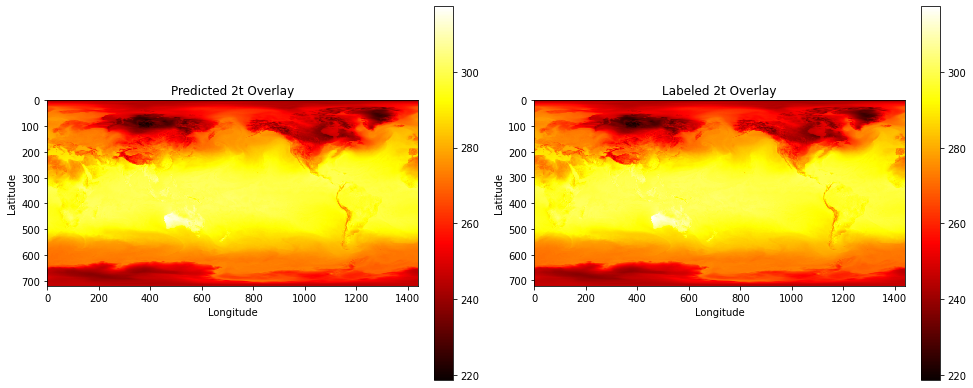

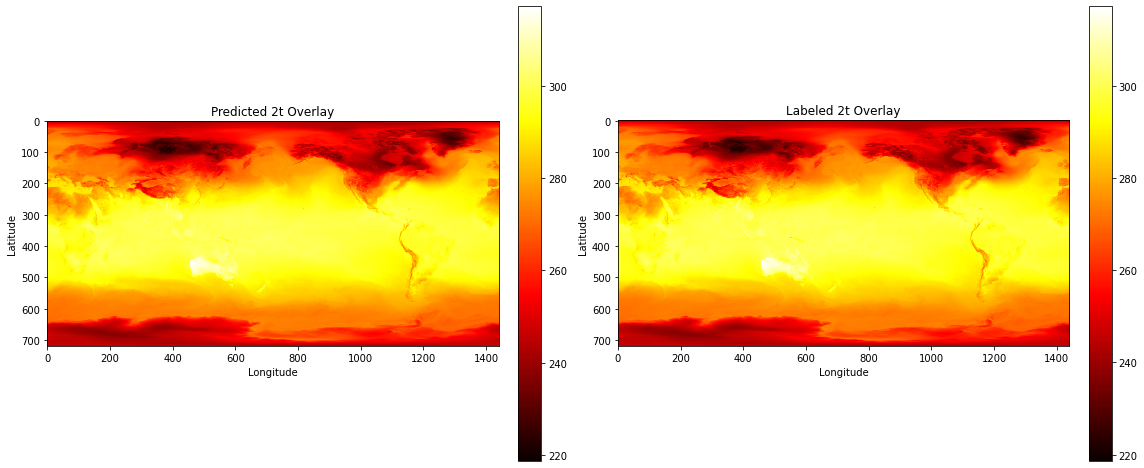

torch.Size([1, 1, 720, 1440])
torch.Size([1, 1, 720, 1440])


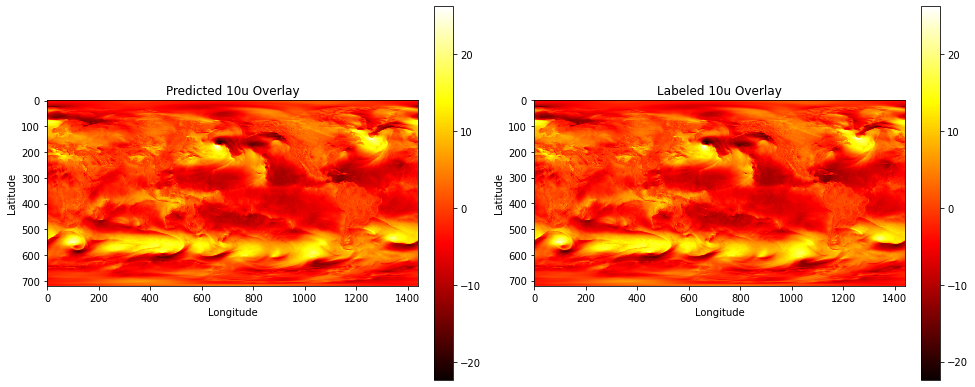

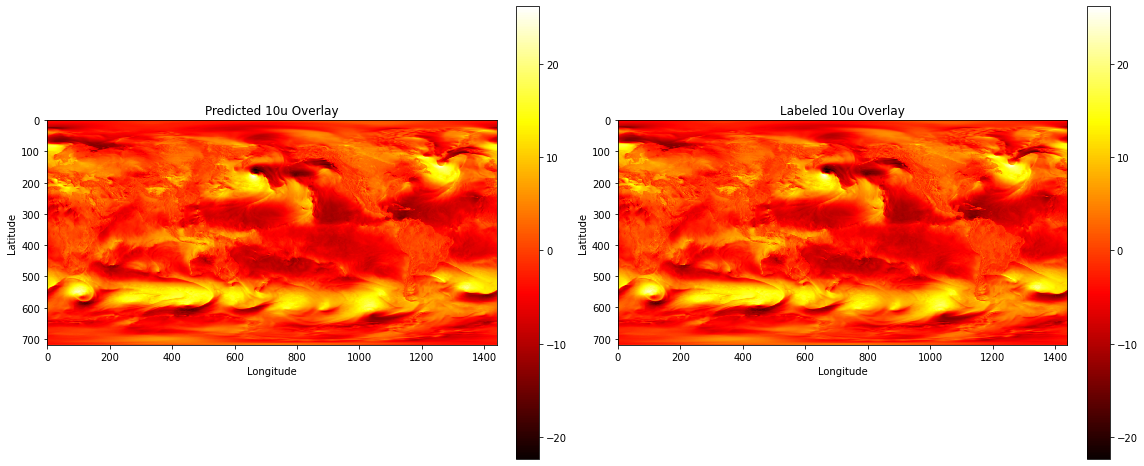

torch.Size([1, 1, 720, 1440])
torch.Size([1, 1, 720, 1440])


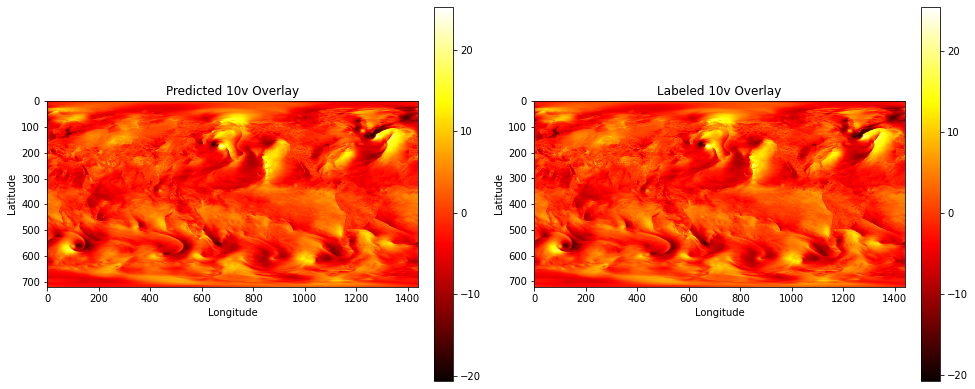

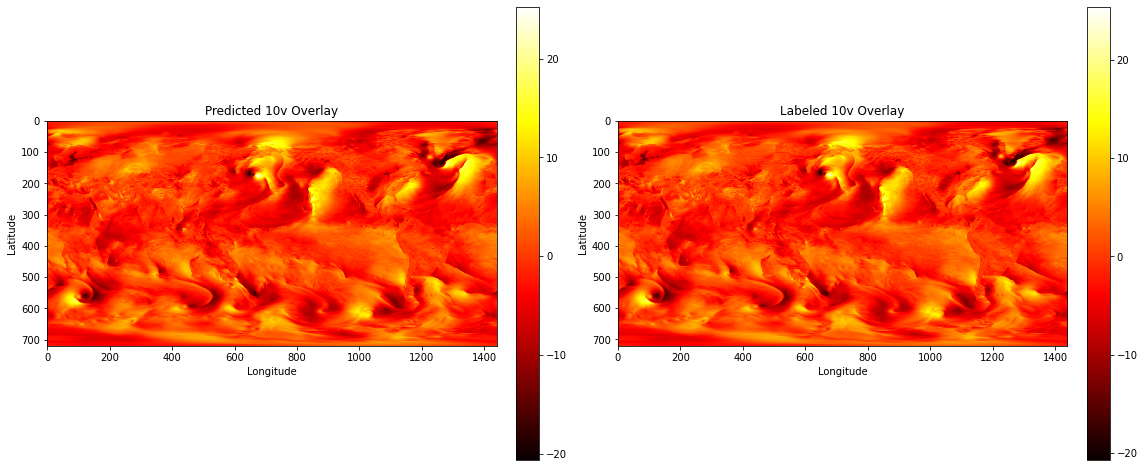

torch.Size([1, 1, 720, 1440])
torch.Size([1, 1, 720, 1440])


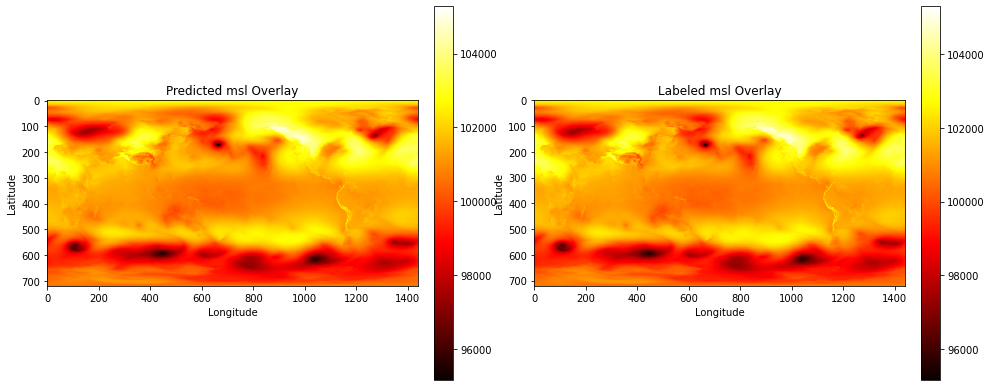

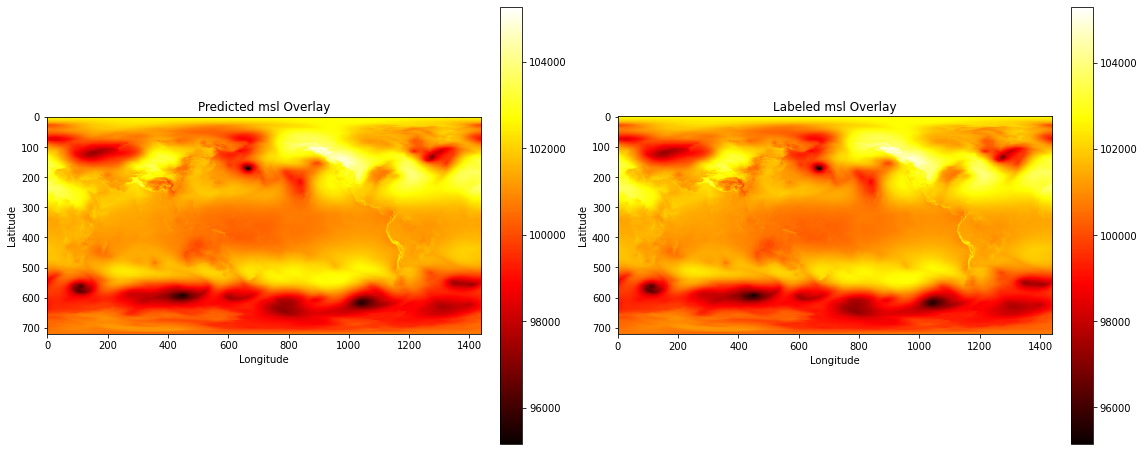

In [52]:

static_vars_ds = xr.open_dataset(f"../{download_path}/static/static.nc", engine="netcdf4")
surf_vars_ds = xr.open_dataset(f"../{download_path}/fle/surf_2015-01-04.nc", engine="netcdf4")
atmos_vars_ds = xr.open_dataset(f"../{download_path}/atmospheric/201501/atmospheric_20150104.nc", engine="netcdf4")


i = 0  # Select this time index in the downloaded data.
surf_size = (720, 1440)
atmos_size = (720, 1440)
output_size = (720, 1440)

surf_vars={
        # First select time points `i` and `i - 1`. Afterwards, `[None]` inserts a
        # batch dimension of size one.
        "2t": torch.from_numpy(surf_vars_ds["t2m"].values[[i]][None]),
        "10u": torch.from_numpy(surf_vars_ds["u10"].values[[ i]][None]),
        "10v": torch.from_numpy(surf_vars_ds["v10"].values[[ i]][None]),
        "msl": torch.from_numpy(surf_vars_ds["msl"].values[[ i]][None])
    }
atmos_vars={
        "t": torch.from_numpy(atmos_vars_ds["t"].values[[ i]][None]),
        "u": torch.from_numpy(atmos_vars_ds["u"].values[[i]][None]),
        "v": torch.from_numpy(atmos_vars_ds["v"].values[[i]][None]),
        "q": torch.from_numpy(atmos_vars_ds["q"].values[[i]][None]),
        "z": torch.from_numpy(atmos_vars_ds["z"].values[[i]][None])
    }

interpolated_surf_vars = {
        key: (F.interpolate(value, size=surf_size, mode='bilinear', align_corners=False) >= 0.5).int()
        if key == "fire" else  F.interpolate(value, size=surf_size, mode='bilinear', align_corners=False)
        for key, value in surf_vars.items()
    }
interpolated_surf_vars2 = {
        key: (F.interpolate(value, size=surf_size, mode='bicubic', align_corners=False) >= 0.5).int()
        if key == "fire" else  F.interpolate(value, size=surf_size, mode='bicubic', align_corners=False)
        for key, value in surf_vars.items()
    }
interpolated_atmos_vars = {
        key: F.interpolate(value.view(-1, 1, 721, 1440), size=atmos_size, mode='bilinear', align_corners=False).view(value.shape[0], value.shape[1], value.shape[2], 720, 1440)
        for key, value in atmos_vars.items()
    }



batch3 = Batch(
    surf_vars=surf_vars,
    static_vars={
        # The static variables are constant, so we just get them for the first time.
        "z": torch.from_numpy(static_vars_ds["z"].values[0]),
        "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
        "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
    },
    atmos_vars=atmos_vars,
    metadata=Metadata(
        lat=torch.from_numpy(surf_vars_ds.latitude.values),
        lon=torch.from_numpy(surf_vars_ds.longitude.values),
        # Converting to `datetime64[s]` ensures that the output of `tolist()` gives
        # `datetime.datetime`s. Note that this needs to be a tuple of length one:
        # one value for every batch element.
        time=(surf_vars_ds.valid_time.values.astype("datetime64[s]").tolist()[i],),
        atmos_levels=tuple(int(level) for level in atmos_vars_ds.pressure_level.values),
    ),
)

print(interpolated_surf_vars['2t'].shape)
for var in interpolated_surf_vars.keys():
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    print(interpolated_surf_vars[var].shape)
    # Plot predicted grid for the current variable
    axes[0].imshow(interpolated_surf_vars[var].squeeze().squeeze(), cmap='hot', interpolation='nearest')
    axes[0].set_title(f'Predicted {var} Overlay')
    axes[0].set_xlabel('Longitude')
    axes[0].set_ylabel('Latitude')
    axes[0].colorbar = fig.colorbar(axes[0].images[0], ax=axes[0], fraction=0.046, pad=0.04)

    # Plot labeled grid for the current variable
    axes[1].imshow(surf_vars[var].squeeze().squeeze(), cmap='hot', interpolation='nearest')
    axes[1].set_title(f'Labeled {var} Overlay')
    axes[1].set_xlabel('Longitude')
    axes[1].set_ylabel('Latitude')
    axes[1].colorbar = fig.colorbar(axes[1].images[0], ax=axes[1], fraction=0.046, pad=0.04)
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    
    print(interpolated_surf_vars2[var].shape)
    # Plot predicted grid for the current variable
    axes[0].imshow(interpolated_surf_vars[var].squeeze().squeeze(), cmap='hot', interpolation='nearest')
    axes[0].set_title(f'Predicted {var} Overlay')
    axes[0].set_xlabel('Longitude')
    axes[0].set_ylabel('Latitude')
    axes[0].colorbar = fig.colorbar(axes[0].images[0], ax=axes[0], fraction=0.046, pad=0.04)

    # Plot labeled grid for the current variable
    axes[1].imshow(surf_vars[var].squeeze().squeeze(), cmap='hot', interpolation='nearest')
    axes[1].set_title(f'Labeled {var} Overlay')
    axes[1].set_xlabel('Longitude')
    axes[1].set_ylabel('Latitude')
    axes[1].colorbar = fig.colorbar(axes[1].images[0], ax=axes[1], fraction=0.046, pad=0.04)

    # Show the plots
    plt.tight_layout()
    plt.show()

In [ ]:
i = 0  # Select this time index in the downloaded data.

batch4 = Batch(
    surf_vars={
        # First select time points `i` and `i - 1`. Afterwards, `[None]` inserts a
        # batch dimension of size one.
        "2t": torch.from_numpy(surf_comb["t2m"].values[[i - 1, i]][None]),
        "10u": torch.from_numpy(surf_comb["u10"].values[[i - 1, i]][None]),
        "10v": torch.from_numpy(surf_comb["v10"].values[[i - 1, i]][None]),
        "msl": torch.from_numpy(surf_comb["msl"].values[[i - 1, i]][None]),
    },
    static_vars={
        # The static variables are constant, so we just get them for the first time.
        "z": torch.from_numpy(static_vars_ds["z"].values[0]),
        "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
        "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
    },
    atmos_vars={
        "t": torch.from_numpy(atmos_comb["t"].values[[i - 1, i]][None]),
        "u": torch.from_numpy(atmos_comb["u"].values[[i - 1, i]][None]),
        "v": torch.from_numpy(atmos_comb["v"].values[[i - 1, i]][None]),
        "q": torch.from_numpy(atmos_comb["q"].values[[i - 1, i]][None]),
        "z": torch.from_numpy(atmos_comb["z"].values[[i - 1, i]][None]),
    },
    metadata=Metadata(
        lat=torch.from_numpy(surf_comb.latitude.values),
        lon=torch.from_numpy(surf_comb.longitude.values),
        # Converting to `datetime64[s]` ensures that the output of `tolist()` gives
        # `datetime.datetime`s. Note that this needs to be a tuple of length one:
        # one value for every batch element.
        time=(surf_comb.valid_time.values.astype("datetime64[s]").tolist()[i],),
        atmos_levels=tuple(int(level) for level in atmos_comb.pressure_level.values),
    ),
)

In [ ]:
from aurora import Aurora, rollout

model2 = Aurora(use_lora=False)  # The pretrained version does not use LoRA.
model2.load_checkpoint("microsoft/aurora", "aurora-0.25-pretrained.ckpt")

model2.eval()
model2 = model2.to("cuda")


In [ ]:

with torch.inference_mode():
    preds = [pred.to("cpu") for pred in rollout(model2, batch4, steps=2)]

model2 = model2.to("cpu")

# torch.stack(list(pred.surf_vars.values())).size()

In [ ]:
preds[1].surf_vars['2t'].size()